# Russian Ukranian war analysis focused on semantics and networks single file rundown

As we worked on the project, we focused on creating a website. For this reason, much of the information asked for in notebook is instead contained on the website. We apologise for not reading the assignment description carefully enough.

This file aims to encapsualte all function and computations done in the effort to analyse the situation, and will therefore exclude the data collections other than a brief description.

The code below was written by Klaus Jupiter Bentzen (s204123), Rune Nedergaard (s202192) and Andreas Krogsgaard Holme (s204160).

The final touches of this notebook was done with haste, as such we didnt have time to compute all plots again, if the plotting code is commented out, it is because we didnt have the time to plot it again, and the correct plot will follow shortly. 

## Workdistribution:
We split the data downloading and first round of handling between us equially.
Andreas did the main cleaning, data restructuring as well as the first sentiment steps
Klaus did the time based sentiment and got the war score as well as created the wordclouds, freq, graphs etc.
Rune assisted in the above and wrote most of the text uploaded to the website and plots used to descibe the dataset. 
Finally Klaus created the website.

## Data Collection

Out data was collected from twitter using the twitter API: (https://developer.twitter.com/en/docs/twitter-api) and was based on data collected by: (https://arxiv.org/abs/2203.02955). 

As such we downloaded the data, using the API and kept the relevant parts, creating a pandas dataframe for each csv file. We cannot share these as it is against twitter policy to do so. The process of doing this took approximatly 16 hours.
The dataframes were then collected into a singular dataframe which then became the working dataframe.
From here, we removed all tweet which didnt belong to someone who had tweeted in either russian or ukrainian during this period. Resulting in a significantly smaller dataset consistsing of slightly less than 2% of the original data. 

This datafile is the one being loaded in below:

In [1]:
### imports:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict

In [26]:
df_ru_uk = pd.read_pickle("./preprocessing/dfs/only_ru_uk_main.pkl")
print("columns:",list(df_ru_uk.columns))
print("N tweets:",len(df_ru_uk.index))

columns: ['user_id', 'parent_id', 'lang', 'text', 'tweet_type', 'created_time', 'hashtags', 'topics', 'mentions']
N tweets: 18315


## Data cleaning and translation

The translation and cleaning code is commented out, as it takes 1+ hour to run, as translation is very slow. Therefore we here simply load a version that already has it.

In [27]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from googletrans import Translator
from emoji_translate.emoji_translate import Translator as emoji_trans
from nltk.tokenize import word_tokenize

import re

translator = Translator()

analyzer = SentimentIntensityAnalyzer()
emo = emoji_trans(exact_match_only=False, randomize=True)

In [43]:

# re_web_finder = r"(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+"

# df_ru_uk["en_text"] = "not_assigned"
# en_text = []
# for i,(txt,lang) in enumerate(zip(df_ru_uk["text"],df_ru_uk["lang"])):

#     for r in re.findall(re_web_finder,txt):
#         txt = txt.replace(r,".")

#     try:
#         if lang != "en":
#             if lang == "uk":
#                 src_lang = "ukrainian"
#             elif lang == "ru":
#                 src_lang = "russian"
#             txt_no_emos = emo.demojify(txt)
#             txt_trans = translator.translate(txt_no_emos,src=src_lang).text
#             txt_trans = word_tokenize(txt_trans)
#             txt_final = " ".join(map(str,txt_trans)).lower()
#             en_text.append(txt_final) 

#         else:
#             txt_no_emos = emo.demojify(txt)
#             txt_trans = word_tokenize(txt_no_emos)
#             txt_final = " ".join(map(str,txt_trans)).lower()
#             en_text.append(txt_final) 
#     except:
#         en_text.append(None)

#     print(i/180,"%")
#     # if i == 100:
#     #     break

# df_ru_uk["en_text"] = en_text

df_ru_uk = pd.read_pickle("./preprocessing/dfs/only_ru_uk_main_translated.pkl")

## Sentiment
Now we will do the sentiment calculations. There are split into multiple parts:

### Tweetwise sentiment

In [210]:
sentiment_list = []
for i,tweet_txt in enumerate(df_ru_uk["en_text"]):
    if tweet_txt is not None:
        compound_sentiment = analyzer.polarity_scores(tweet_txt)
        sentiment_list.append(compound_sentiment)
    else:
        sentiment_list.append(None)

df_ru_uk["sentiment_scores"] = sentiment_list

### Window sentiment

In [45]:
from nltk.text import Text
s_analyzer = SentimentIntensityAnalyzer()

keys = ["neg", "neu","pos","compound"]
search_words = ["ukraine","russia","putin","zelensky","zelenskyy"]


In [46]:
## Helper functions
def window_sentiment(txt,word,window_size):
    concordance = Text(word_tokenize(txt)).concordance_list(word,width=window_size*10)
    sentiment_list = []
    for concor in concordance:
        txt_list = concor.left[-window_size:] + concor.right[:window_size]
        txt = " ".join(map(str,txt_list))
        sentiment_list.append(s_analyzer.polarity_scores(txt))
    return sentiment_list

def equalize_sentiment(sentiment_list,keys=keys):
    N = len(sentiment_list)
    d = {key:0 for key in keys}
    for sentiment_dicts in sentiment_list:
        for key in keys:
            d[key] += sentiment_dicts[key]/N
    return d

def sentiment_dict_from_txt(txt,search_words = search_words):
    topic_d = {}
    for word in search_words:
        sentiment_list = window_sentiment(txt,word,5)
        if len(sentiment_list) == 1:
            topic_d[word] = sentiment_list[0]
        else:
            topic_d[word] = equalize_sentiment(sentiment_list)
    zelensky_list = [topic_d["zelensky"],topic_d["zelenskyy"]]
    topic_d["zelenskyy"] = equalize_sentiment(zelensky_list)
    del topic_d["zelensky"]
    return topic_d

In [47]:
wordwise_sentiment_list = []
for i,en_text in enumerate(df_ru_uk["en_text"]):
    if en_text is not None:
        sent_d = sentiment_dict_from_txt(en_text)
        wordwise_sentiment_list.append(sent_d)
    else:
        wordwise_sentiment_list.append(None)

df_ru_uk["sentiment_dict"] = wordwise_sentiment_list


## Mentioned presidents

In [150]:
def common_member(a, b):
    a_set = set(a)
    b_set = set(b)
    if (a_set & b_set):
        return True 
    else:
        return False

In [155]:
putin_words = ["Putin","Vladimir Putin", "putin","vladimir putin"] # dublicate words should be removed when the data is gernereated again, as all will be lower then
zelen_words = ["Volodymyr","Volodymyr Zelenskyy","Zelenskyy","volodymyr zelenskyy","volodymyr","zelenskyy","ZelenskyyUa","Volodymyr Zelensky","Zelensky","zelensky","zelenskyyua"]
re_quote = r"\'(.*?)\'"
path = './preprocessing/dfs/translated-text-ru-uk_sentiment_n.pkl'
df_ru_uk =pd.read_pickle(path)

def get_president_data(dataframe):
    p,z = 0,0
    topics = dataframe["topics"]
    hastags = dataframe["hashtags"]

    president_list = []
    
    for i in range(len(topics)):
        tweet_topics = topics[i]+hastags[i] #re.findall(re_quote,topics[i]+hastags[i]) 
        tweet_president_list = []
        if common_member(tweet_topics,putin_words):
            tweet_president_list.append("putin")
            p+= 1

        if common_member(tweet_topics,zelen_words):
            tweet_president_list.append("zelenskyy")
            z+= 1

        president_list.append(tweet_president_list)

    print("People who mention Putin:",p,"\nPeople who mention Zelenskyy:",z)
    return president_list

In [156]:
president_to_df_list = get_president_data(df_ru_uk)
df_ru_uk["president_mentioned"] = president_to_df_list


People who mention Putin: 1491 
People who mention Zelenskyy: 88


## Word frequency 

In [157]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates



In [158]:
def setup_plot():
    mpl.rcParams['lines.linewidth'] = 1
    #mpl.rcParams['font.family'] = 'Microsoft Sans Serif'
    mpl.rcParams['font.family'] = 'Arial'

    
    #these don't work for some reason
    #mpl.rcParams['axes.titleweight'] = 'bold'
    #mpl.rcParams['axes.titlesize'] = '90'
    
    sns.set_theme(style="white", palette='pastel', font = 'Arial', font_scale=1.5)

    #sns.set_theme(style="white", palette='pastel', font = 'Microsoft Sans Serif', font_scale=1)
    #myFmt = mdates.DateFormatter('%b #Y')
    
    print("Plot settings applied")

setup_plot()

Plot settings applied


In [159]:
from nltk import FreqDist
import string, unicodedata
import nltk
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

#### Helper functions

In [160]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        if word.isdigit():
            continue
        else:
            new_words.append(word)
    return new_words


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    return words

def preprocess(sample):
    sample = remove_URL(sample)
    sample = replace_contractions(sample)
    # Tokenize
    words = nltk.word_tokenize(sample)

    # Normalize
    return normalize(words)

In [161]:
def president_conversion(presidents):
    """
    0 -> No presidents
    1 -> putin
    2 -> zelenskyy
    3 -> putin and zelenskyy
    """
    return ('putin' in presidents) + ('zelenskyy' in presidents) * 2

In [162]:
def is_not_none(val):
    return val is not None

def is_not_empty(item):
    return len(item) != 0

def get_president_text(df, normalize=True):
    p_all = df[(df['president_mention_idx'] == 1).to_numpy()]
    p_text = " ".join(p_all.iloc[np.vectorize(is_not_none)(p_all['en_text'])]['en_text'])
    
    z_all = df[(df['president_mention_idx'] == 2).to_numpy()]
    z_text = " ".join(z_all.iloc[np.vectorize(is_not_none)(z_all['en_text'])]['en_text'])
    
    if normalize:
        p_text = preprocess(p_text)
        z_text = preprocess(z_text)
        p_text = " ".join(p_text)
        z_text = " ".join(z_text)
    
    return p_text, z_text

def get_text(df):
    return df.iloc[np.vectorize(is_not_none)(df['en_text'])]['en_text']

In [163]:
def get_lang(df, lang):
    return df[(df['lang'] == lang).to_numpy()]

def get_nationality(df, nationality):
    return df[(df['nationality'] == nationality).to_numpy()]

#### Get masks

In [164]:
putin_mask = np.array(Image.open('word-frequency/image-mask/p.png'))
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

#### Get subdict, Freq dicts and corresponding list

In [182]:


df_ru_uk['date'] = pd.to_datetime(df_ru_uk['created_time'])
df_ru_uk.index = df_ru_uk['date']

df_ru_uk['president_mention_idx'] = np.vectorize(president_conversion)(df_ru_uk['president_mentioned'].to_numpy())

df_uk = get_nationality(df_ru_uk, 'uk') 
df_ru = get_nationality(df_ru_uk, 'ru') 


In [ ]:
p_text, z_text = get_president_text(df_ru_uk)

text = " ".join(preprocess(" ".join(get_text(df_ru_uk).to_numpy())))

freq_dist = FreqDist(text.split(' '))

freq_list = list(*zip(*sorted(list(zip(freq_dist.items())),key= lambda x: x[0][1], reverse=True)))
n = sum(freq_dist.values())
freq_list = [(x[0],x[1]/n) for x in freq_list]


#### Most frequent words for all

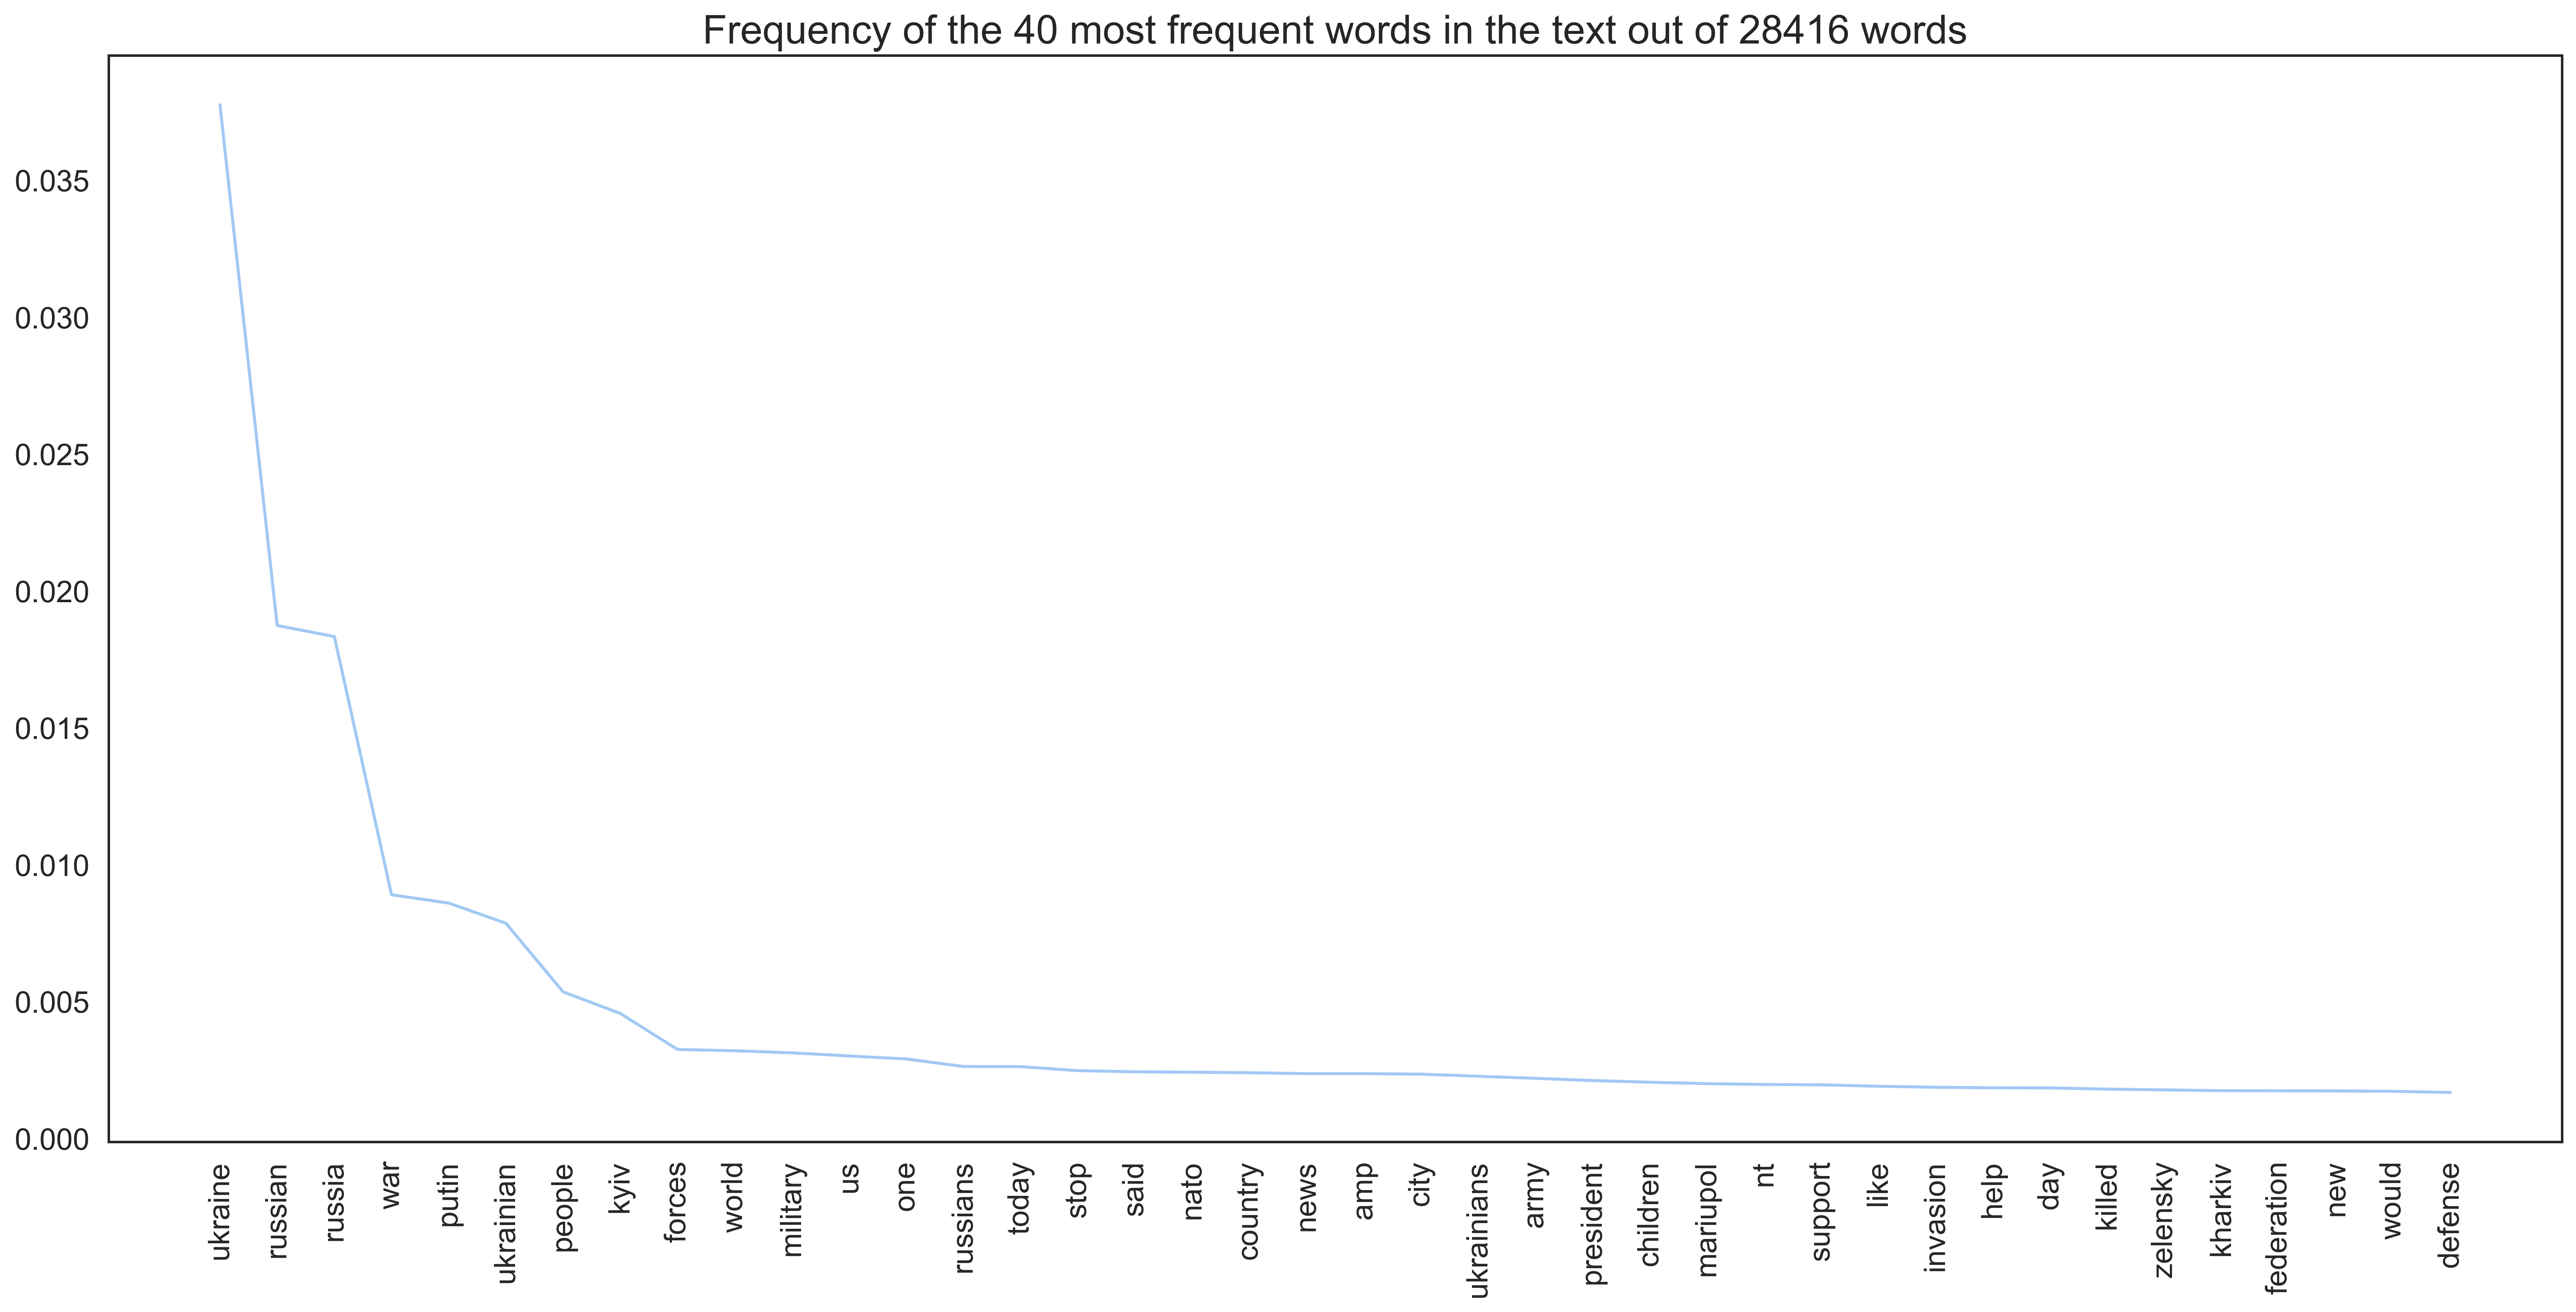

In [168]:
fig, ax = plt.subplots(figsize=(22,10),dpi=400)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
N = 40
ax.plot(*zip(*freq_list[:N]))
plt.title(label=f'Frequency of the {N} most frequent words in the text out of {len(freq_dist)} words', fontdict={'fontsize': 20});
plt.show()
plt.close()

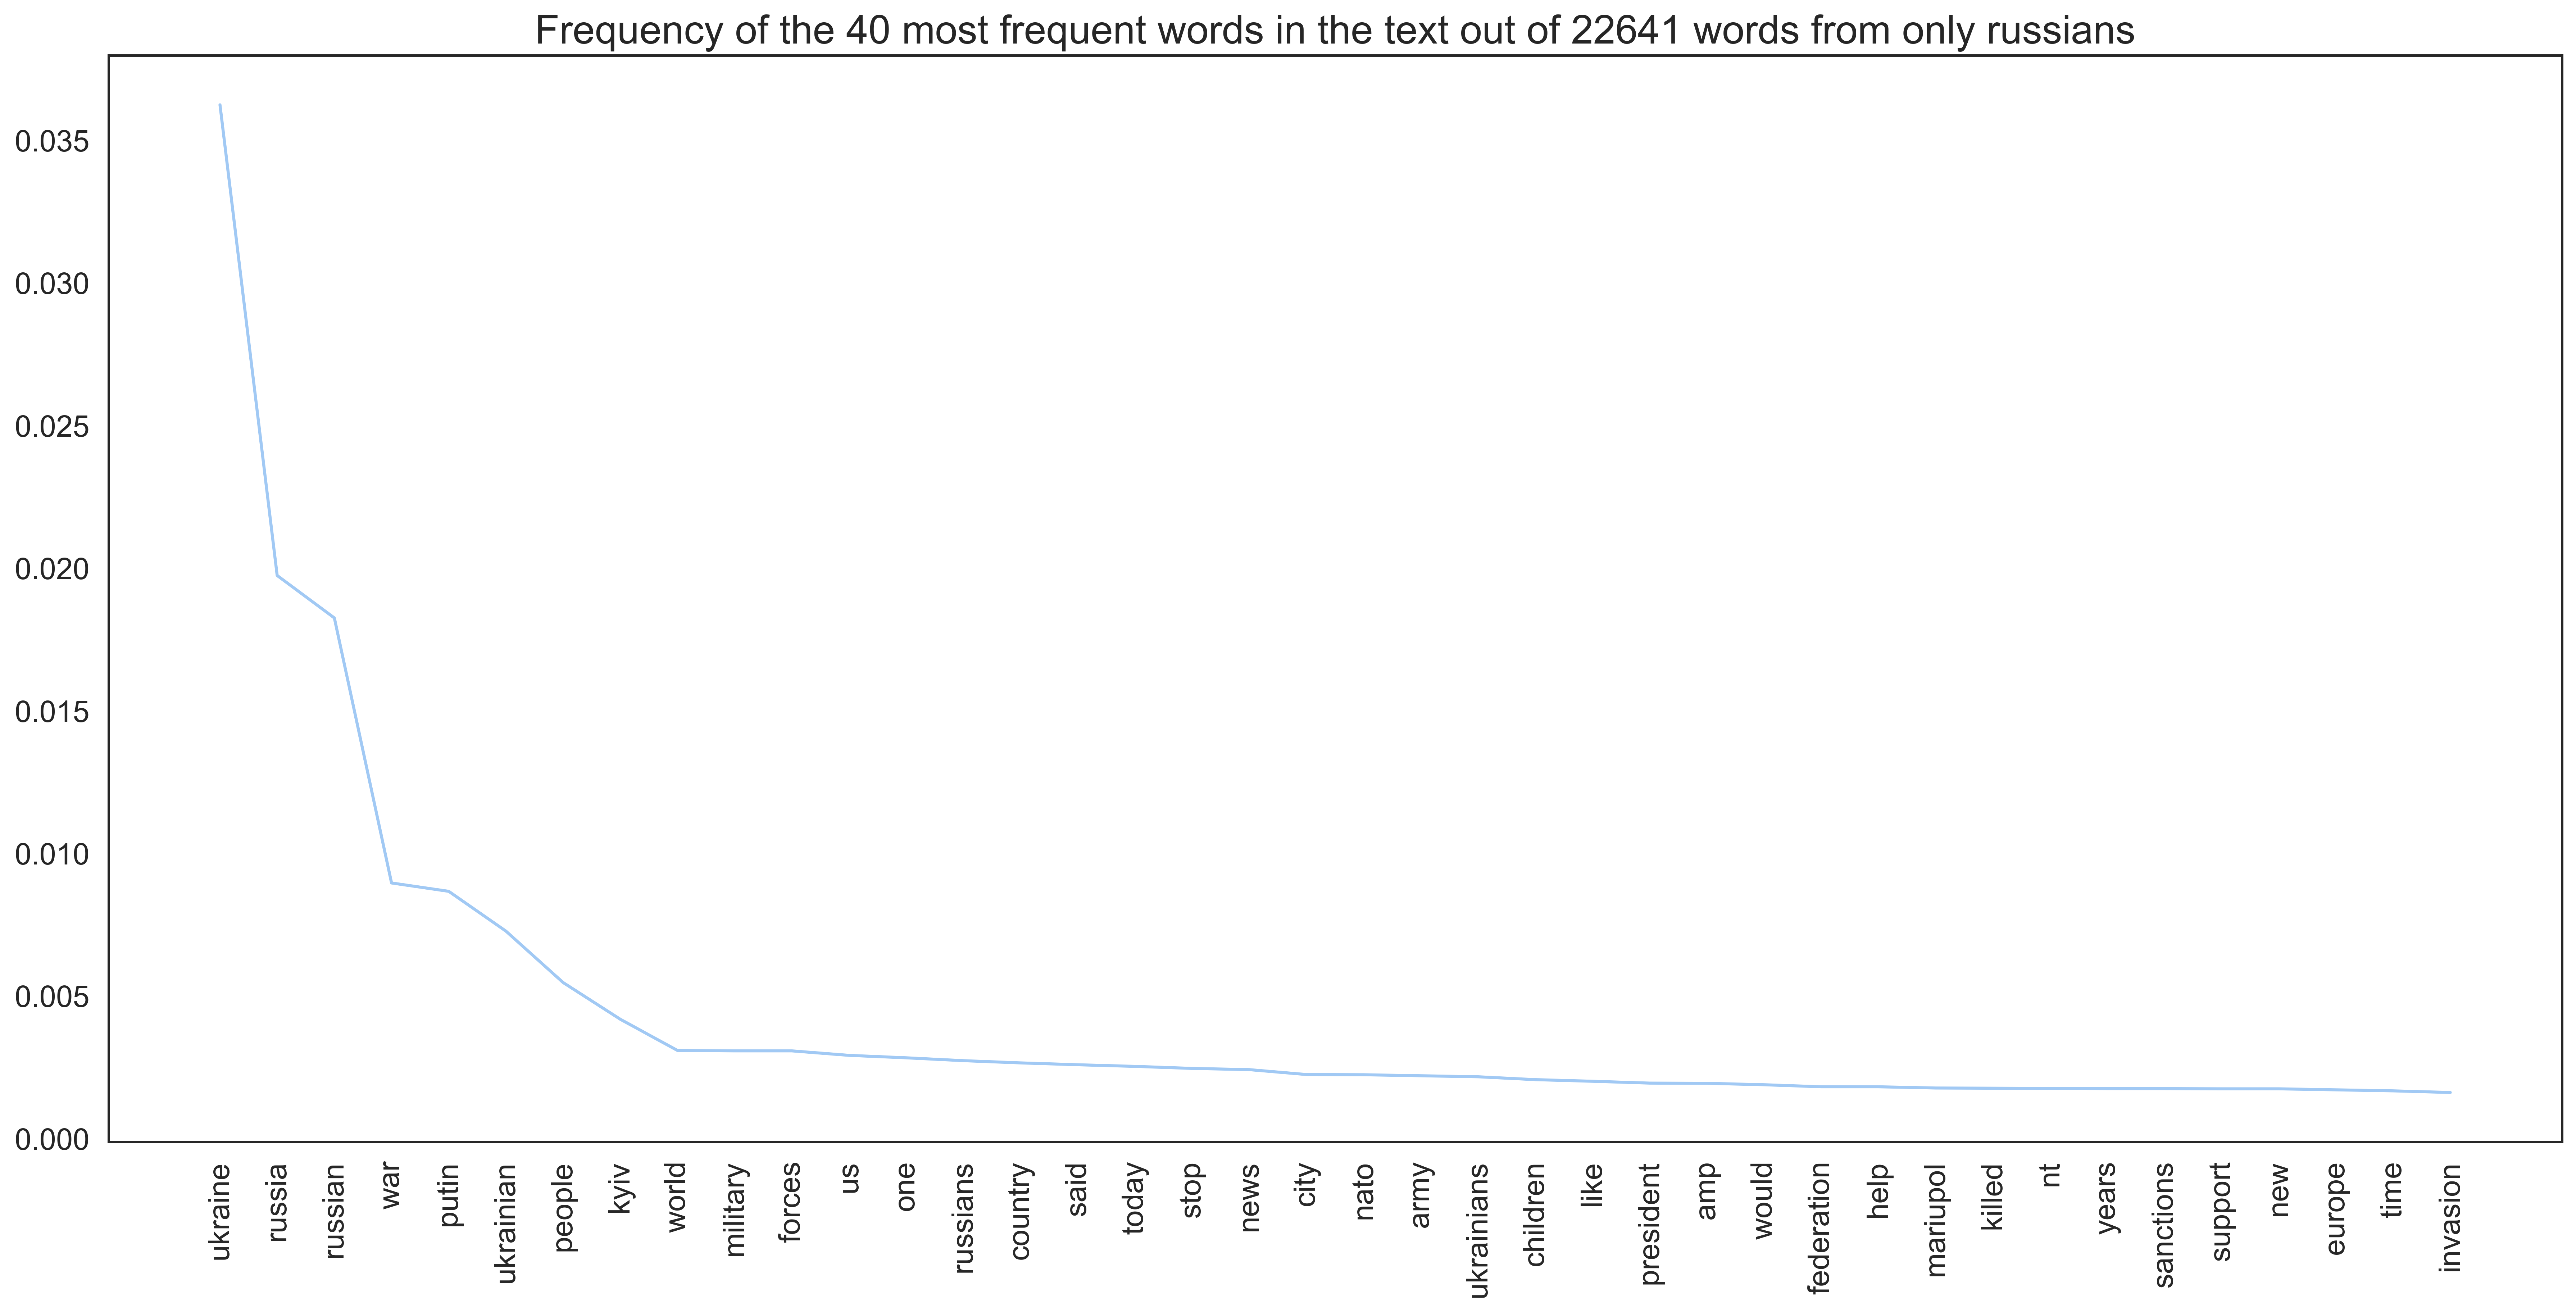

In [180]:
text_ru = " ".join(preprocess(" ".join(get_text(df_ru).to_numpy())))

freq_dist = FreqDist(text_ru.split(' '))

freq_list = list(*zip(*sorted(list(zip(freq_dist.items())),key= lambda x: x[0][1], reverse=True)))
n = sum(freq_dist.values())
freq_list = [(x[0],x[1]/n) for x in freq_list]

fig, ax = plt.subplots(figsize=(22,10),dpi=400)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
N = 40
ax.plot(*zip(*freq_list[:N]))
plt.title(label=f'Frequency of the {N} most frequent words in the text out of {len(freq_dist)} words from only russians', fontdict={'fontsize': 20});
plt.show()
plt.close()

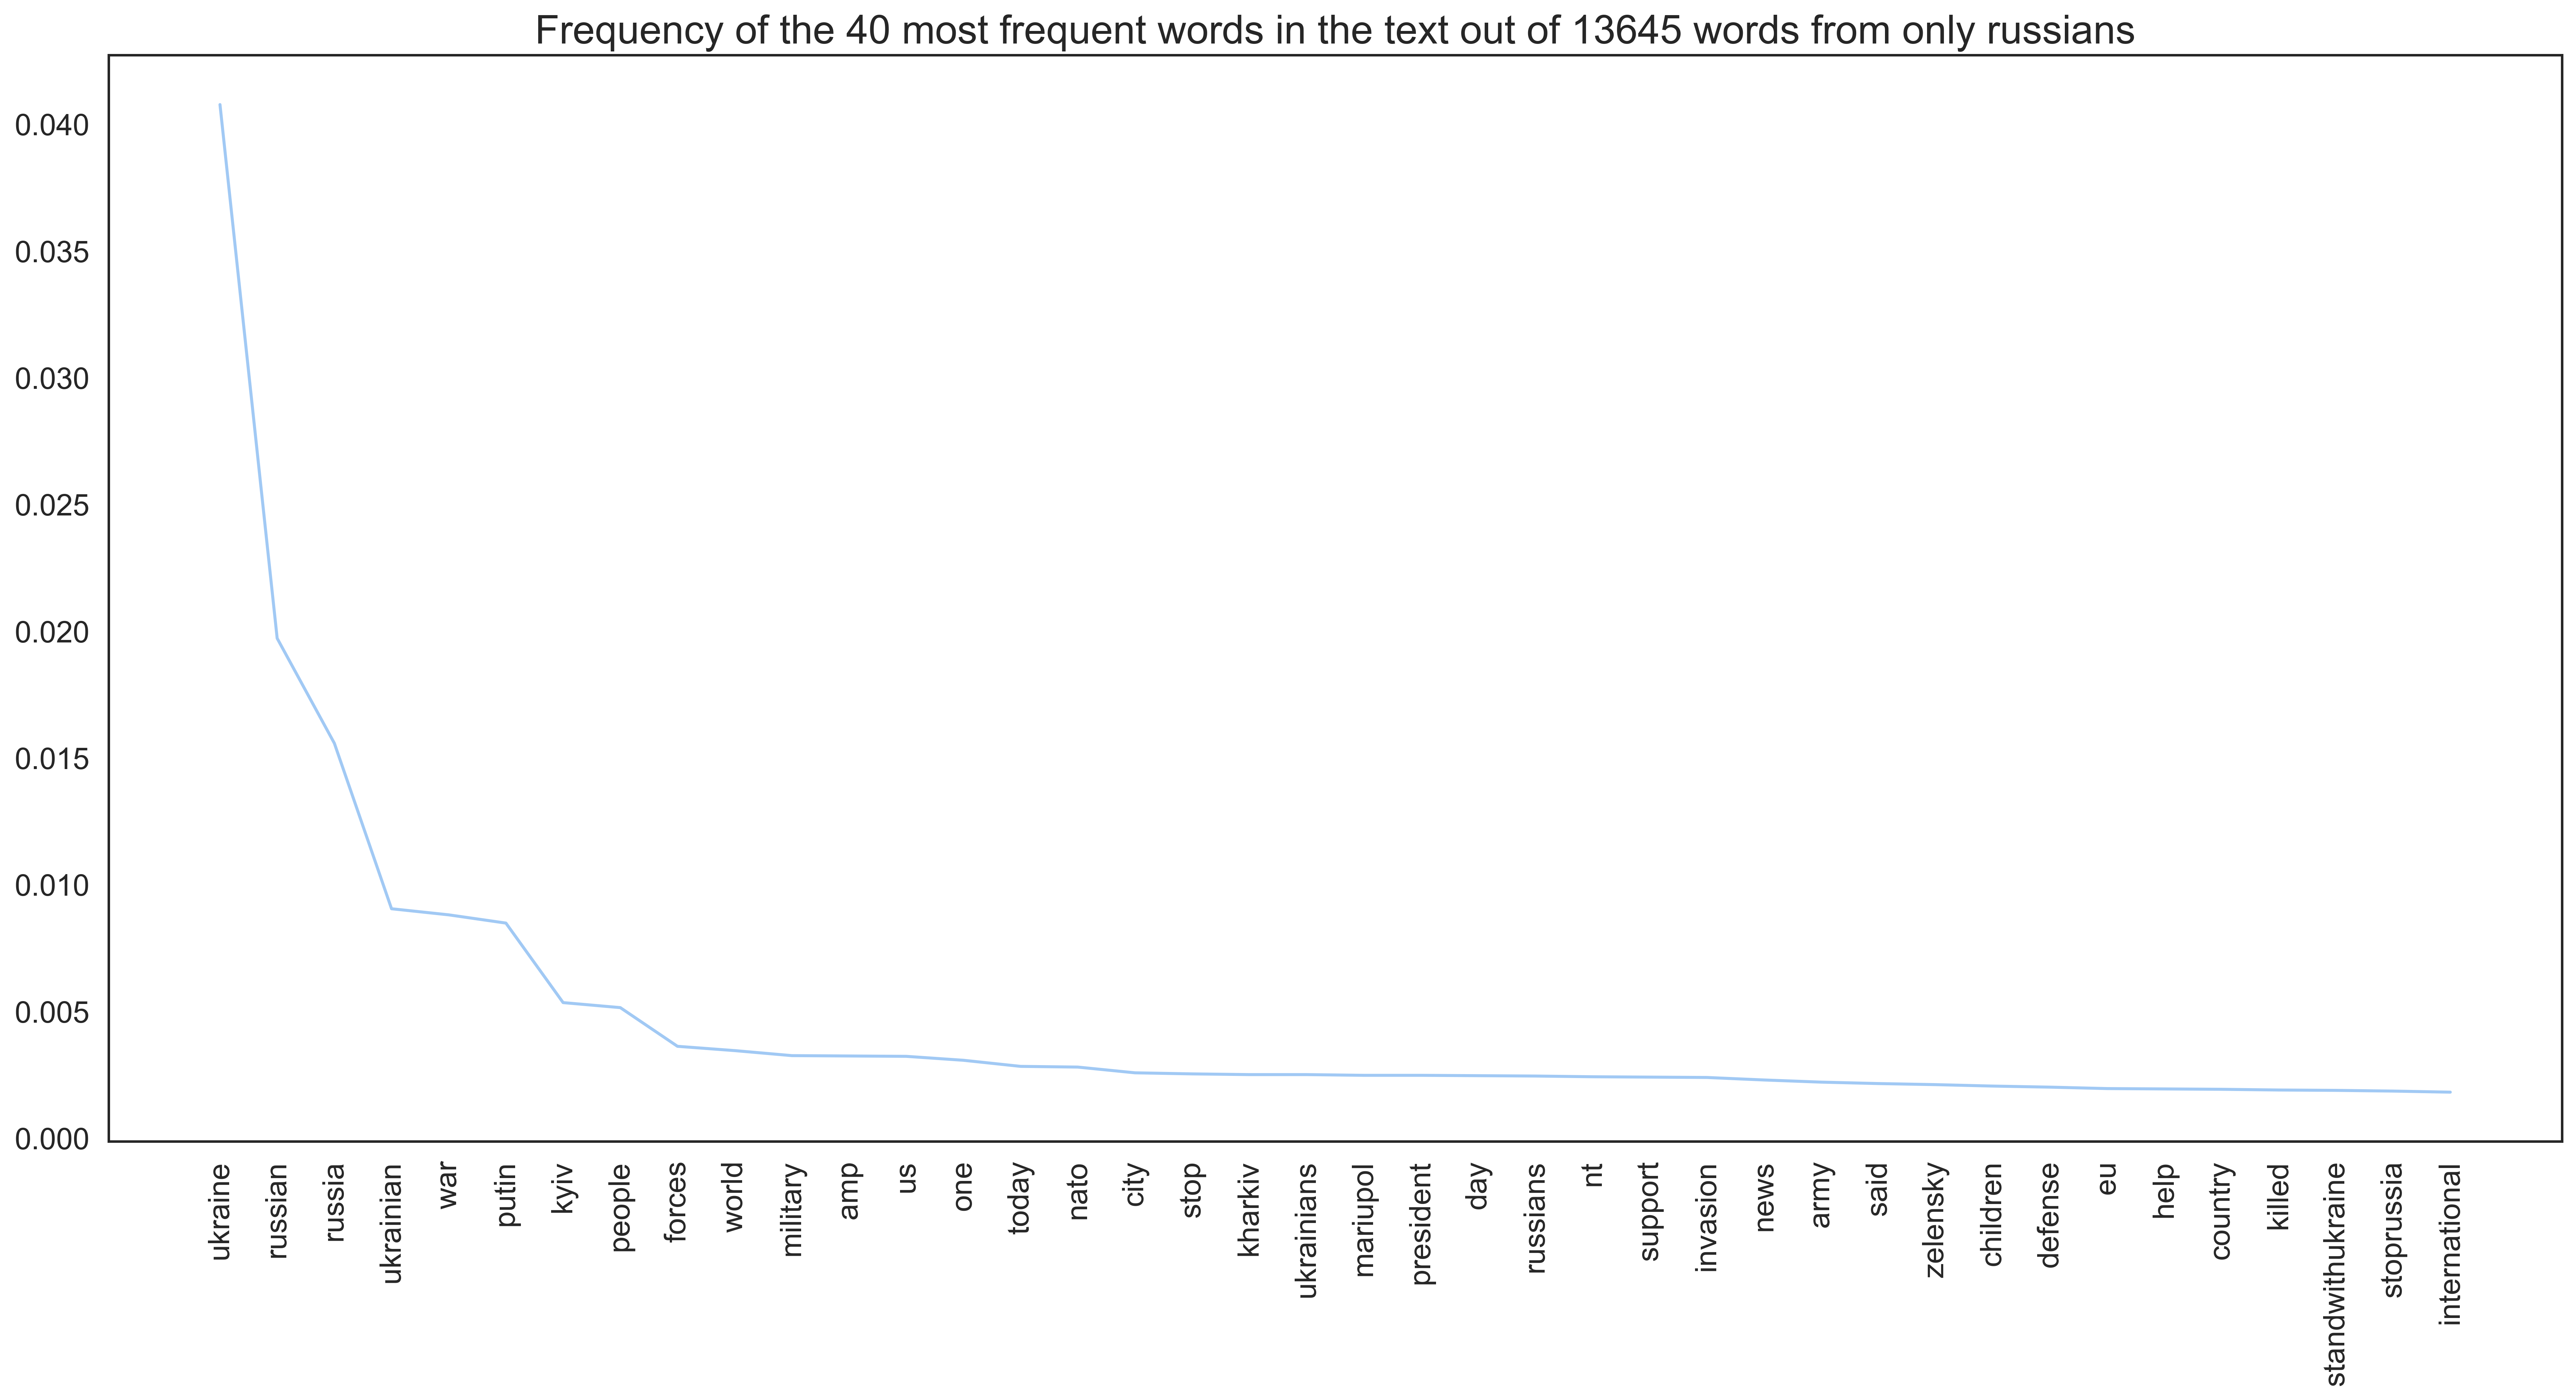

In [181]:
text_uk = " ".join(preprocess(" ".join(get_text(df_uk).to_numpy())))

freq_dist = FreqDist(text_uk.split(' '))

freq_list = list(*zip(*sorted(list(zip(freq_dist.items())),key= lambda x: x[0][1], reverse=True)))
n = sum(freq_dist.values())
freq_list = [(x[0],x[1]/n) for x in freq_list]

fig, ax = plt.subplots(figsize=(22,10),dpi=400)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
N = 40
ax.plot(*zip(*freq_list[:N]))
plt.title(label=f'Frequency of the {N} most frequent words in the text out of {len(freq_dist)} words from only russians', fontdict={'fontsize': 20});
plt.show()
plt.close()

#### Dispersion plot

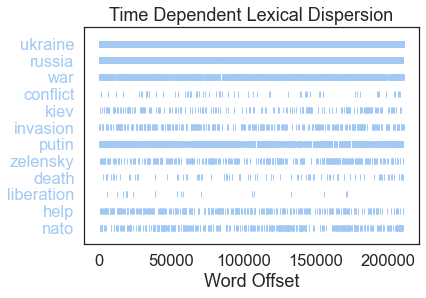

In [169]:
# war, conflict, invasion, putin, zelensky, kiev, andre byer, liberation
nltk.draw.dispersion_plot(text.split(' '), ['ukraine', 'russia', 'war', 'conflict', 'kiev', 'invasion', 'putin', 'zelensky', 'death', 'liberation', 'help', 'nato'], title='Time Dependent Lexical Dispersion')

#### Cool word clouds 

"Someone" forgot to uoload  the background images for these, so I uploaded the final image that would be created below

In [2]:
# def convert(image):
#     f = image.flatten()
#     for i, pixel in enumerate(f):
#         if pixel > 50:
#             f[i] = 255
#     return f.reshape(image.shape)
# path = './word-frequency/image-mask/putin-zelensky-2.jpg'
# img = Image.open(path)
# imgG = img.convert('L')
# Image.fromarray(convert(np.array(imgG))).save('./img-mask.png')   

In [3]:
def color_wordcloud(image, color_image, text, visualize=True, background_color="black", contour_color='white', contour_width=1):
    wc = WordCloud(background_color=background_color, max_words=10000, mask=image,
                    contour_width=contour_width,mode='RGB',width=500,height=500, contour_color=contour_color).generate(text)
    image_colors = ImageColorGenerator(color_image)
    plt.figure(figsize=[40,40],dpi=100)
    word_cloud = wc.recolor(color_func=image_colors)
    if visualize:
        plt.imshow(word_cloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
        plt.close()
    return word_cloud

# # change these paths later
# path = '/word-frequency/image-mask/p.png'
# putin_mask = np.array(Image.open(path))
# path_color = '/word-frequency/image-mask/p-color.png'
# putin_color = np.array(Image.open(path_color))

# p_word = color_wordcloud(putin_mask, putin_color, p_text, visualize=False)

# # change these paths later
# path = '/word-frequency/image-mask/z.png'
# z_img = np.array(Image.open(path))
# path_color = '/word-frequency/image-mask/z-color.png'
# z_color = np.array(Image.open(path_color))

# z_word = color_wordcloud(z_img, z_color, z_text, visualize=False)

def extend_image(images):
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im

# images = [z_word.to_image(),p_word.to_image()]
# new_im = extend_image(images)
# new_im.save('/word-frequency/image-mask/z_p.png')
# new_im

#### For both russians and ukrainians

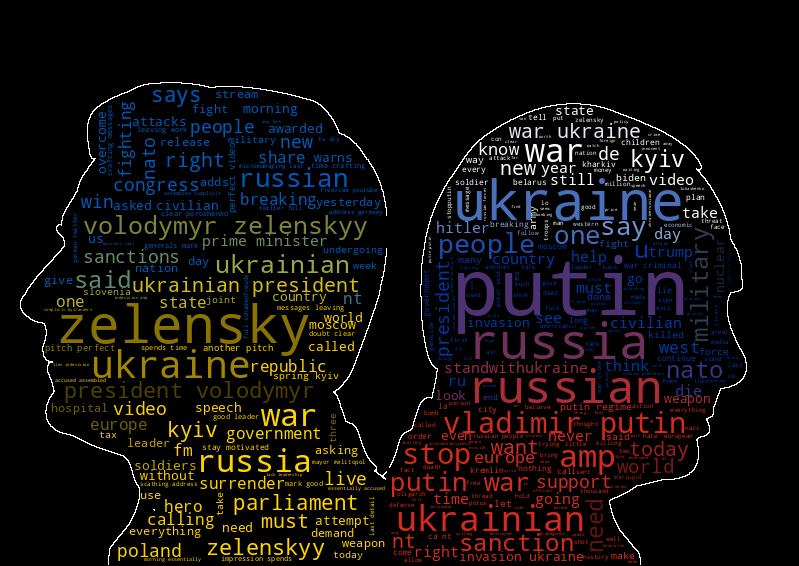

In [175]:
from IPython.display import Image
Image(filename="./img/word_cloud_p_z_all.png") 


#### ukrainians

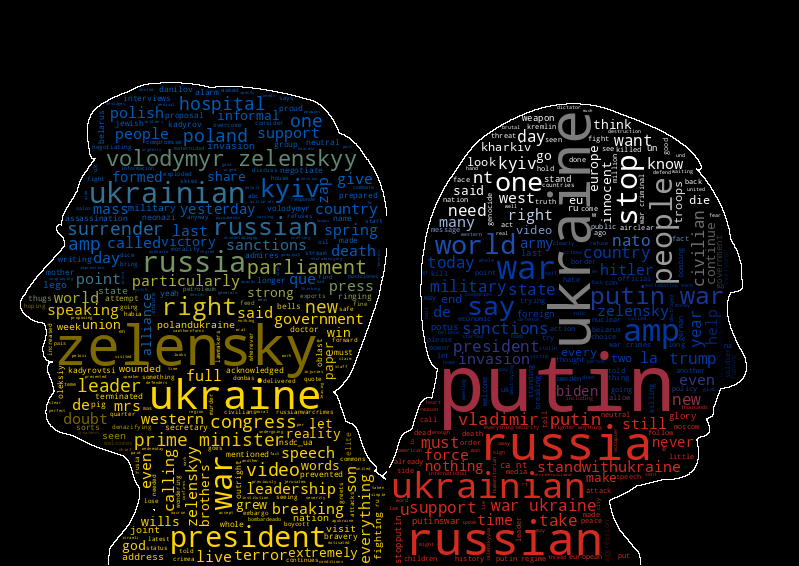

In [177]:
Image(filename="./img/word_cloud_p_z_uk.png") 


#### russians

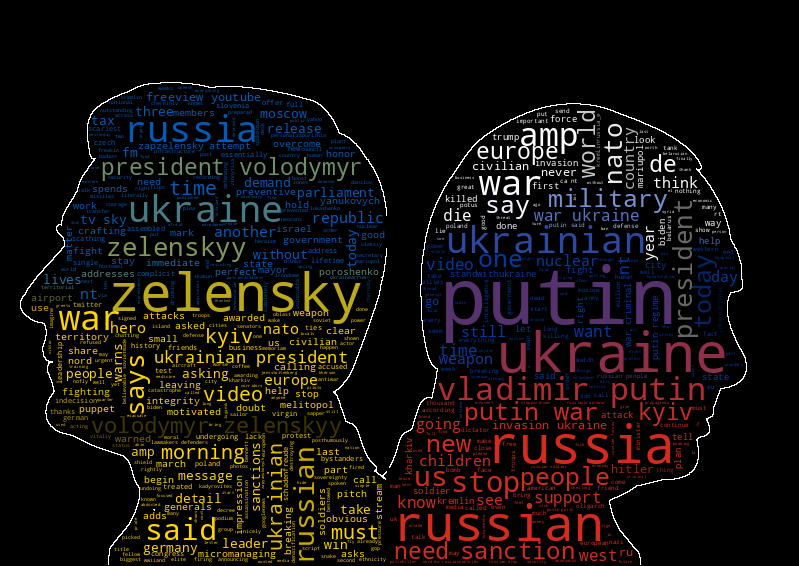

In [176]:
Image(filename="./img/word_cloud_p_z_ru.png") 

## Sentiment over time


In [184]:
import matplotlib.dates as mdates
from re import I 

def setup_plot():
    mpl.rcParams['lines.linewidth'] = 1
    #mpl.rcParams['font.family'] = 'Microsoft Sans Serif'
    mpl.rcParams['font.family'] = 'Arial'

    
    #these don't work for some reason
    #mpl.rcParams['axes.titleweight'] = 'bold'
    #mpl.rcParams['axes.titlesize'] = '90'
    
    sns.set_theme(style="white", palette='pastel', font = 'Arial', font_scale=1.5)

    #sns.set_theme(style="white", palette='pastel', font = 'Microsoft Sans Serif', font_scale=1)
    #myFmt = mdates.DateFormatter('%b #Y')
    
    print("Plot settings applied")

setup_plot()

Plot settings applied


In [186]:
path = "preprocessing/dfs/translated-text-ru-uk_sentiment.pkl"
df =pd.read_pickle(path)

In [189]:
df_ru_uk['date'] = pd.to_datetime(df_ru_uk['created_time'])
df_ru_uk.index = df_ru_uk['date']

In [190]:
def get_lang(df, lang):
    return df[(df['lang'] == lang).to_numpy()]

def get_nationality(df, nationality):
    return df[(df['nationality'] == nationality).to_numpy()]

df_uk = get_nationality(df_ru_uk, 'uk') 
df_uk = get_nationality(df_ru_uk, 'uk') 
df_ru = get_lang(df_ru_uk, 'ru') 
df_ru = get_lang(df_ru_uk, 'ru') 

In [191]:
def get_daily_sentiment(df, keys=[], dates = None):
    dates = dates if dates is not None else np.unique(np.vectorize(str)(df['date'].dt.date.values))

    # Will contain the cummulative sentiment of each of the keys for each day.
    daily_sentiment = {date: {} for date in dates}
    for date in dates:
        sentiment = {key: 0 for key in keys}
        key_count = {key: 0 for key in keys}
        try:
            date_df = df.loc[str(date)]
        except KeyError:
            date_df = None
            print(f"{date} was not found in dataset")
        if date_df is not None:
            for s in date_df['sentiment_dict'].iloc[:]:
                if s is not None:
                    for key in keys:
                        s_val = s.get(key)
                        if s_val is not None:
                            sentiment[key] += s_val['compound']
                            key_count[key] += 1
            for key in keys:
                sentiment[key] /= key_count[key]
        daily_sentiment[date] = sentiment
    return daily_sentiment

keys=['ukraine', 'russia','putin', 'zelenskyy']
daily_sentiment = get_daily_sentiment(df_ru_uk, keys=keys) 


In [193]:
def sentiment_plot(sentiment_dict, keys, title=None):
    fig, ax = plt.subplots(figsize=(22,10),dpi=400)
    plt.xticks(rotation=90,fontsize=15)
    plt.yticks(fontsize=15)
    x, sentiment_values = zip(*sentiment_dict.items())
    for key in keys:
        ax.plot(x, [s[key] for s in sentiment_values])

    ax.plot(x, np.zeros(len(x)), color='black', linestyle=(0,(5,15)))
    # Maybe not 0 line?
    ax.legend(labels=keys+['0 line'])
    plt.title('Sentiment values over time' if title is None else title)

    plt.show()
    plt.close()

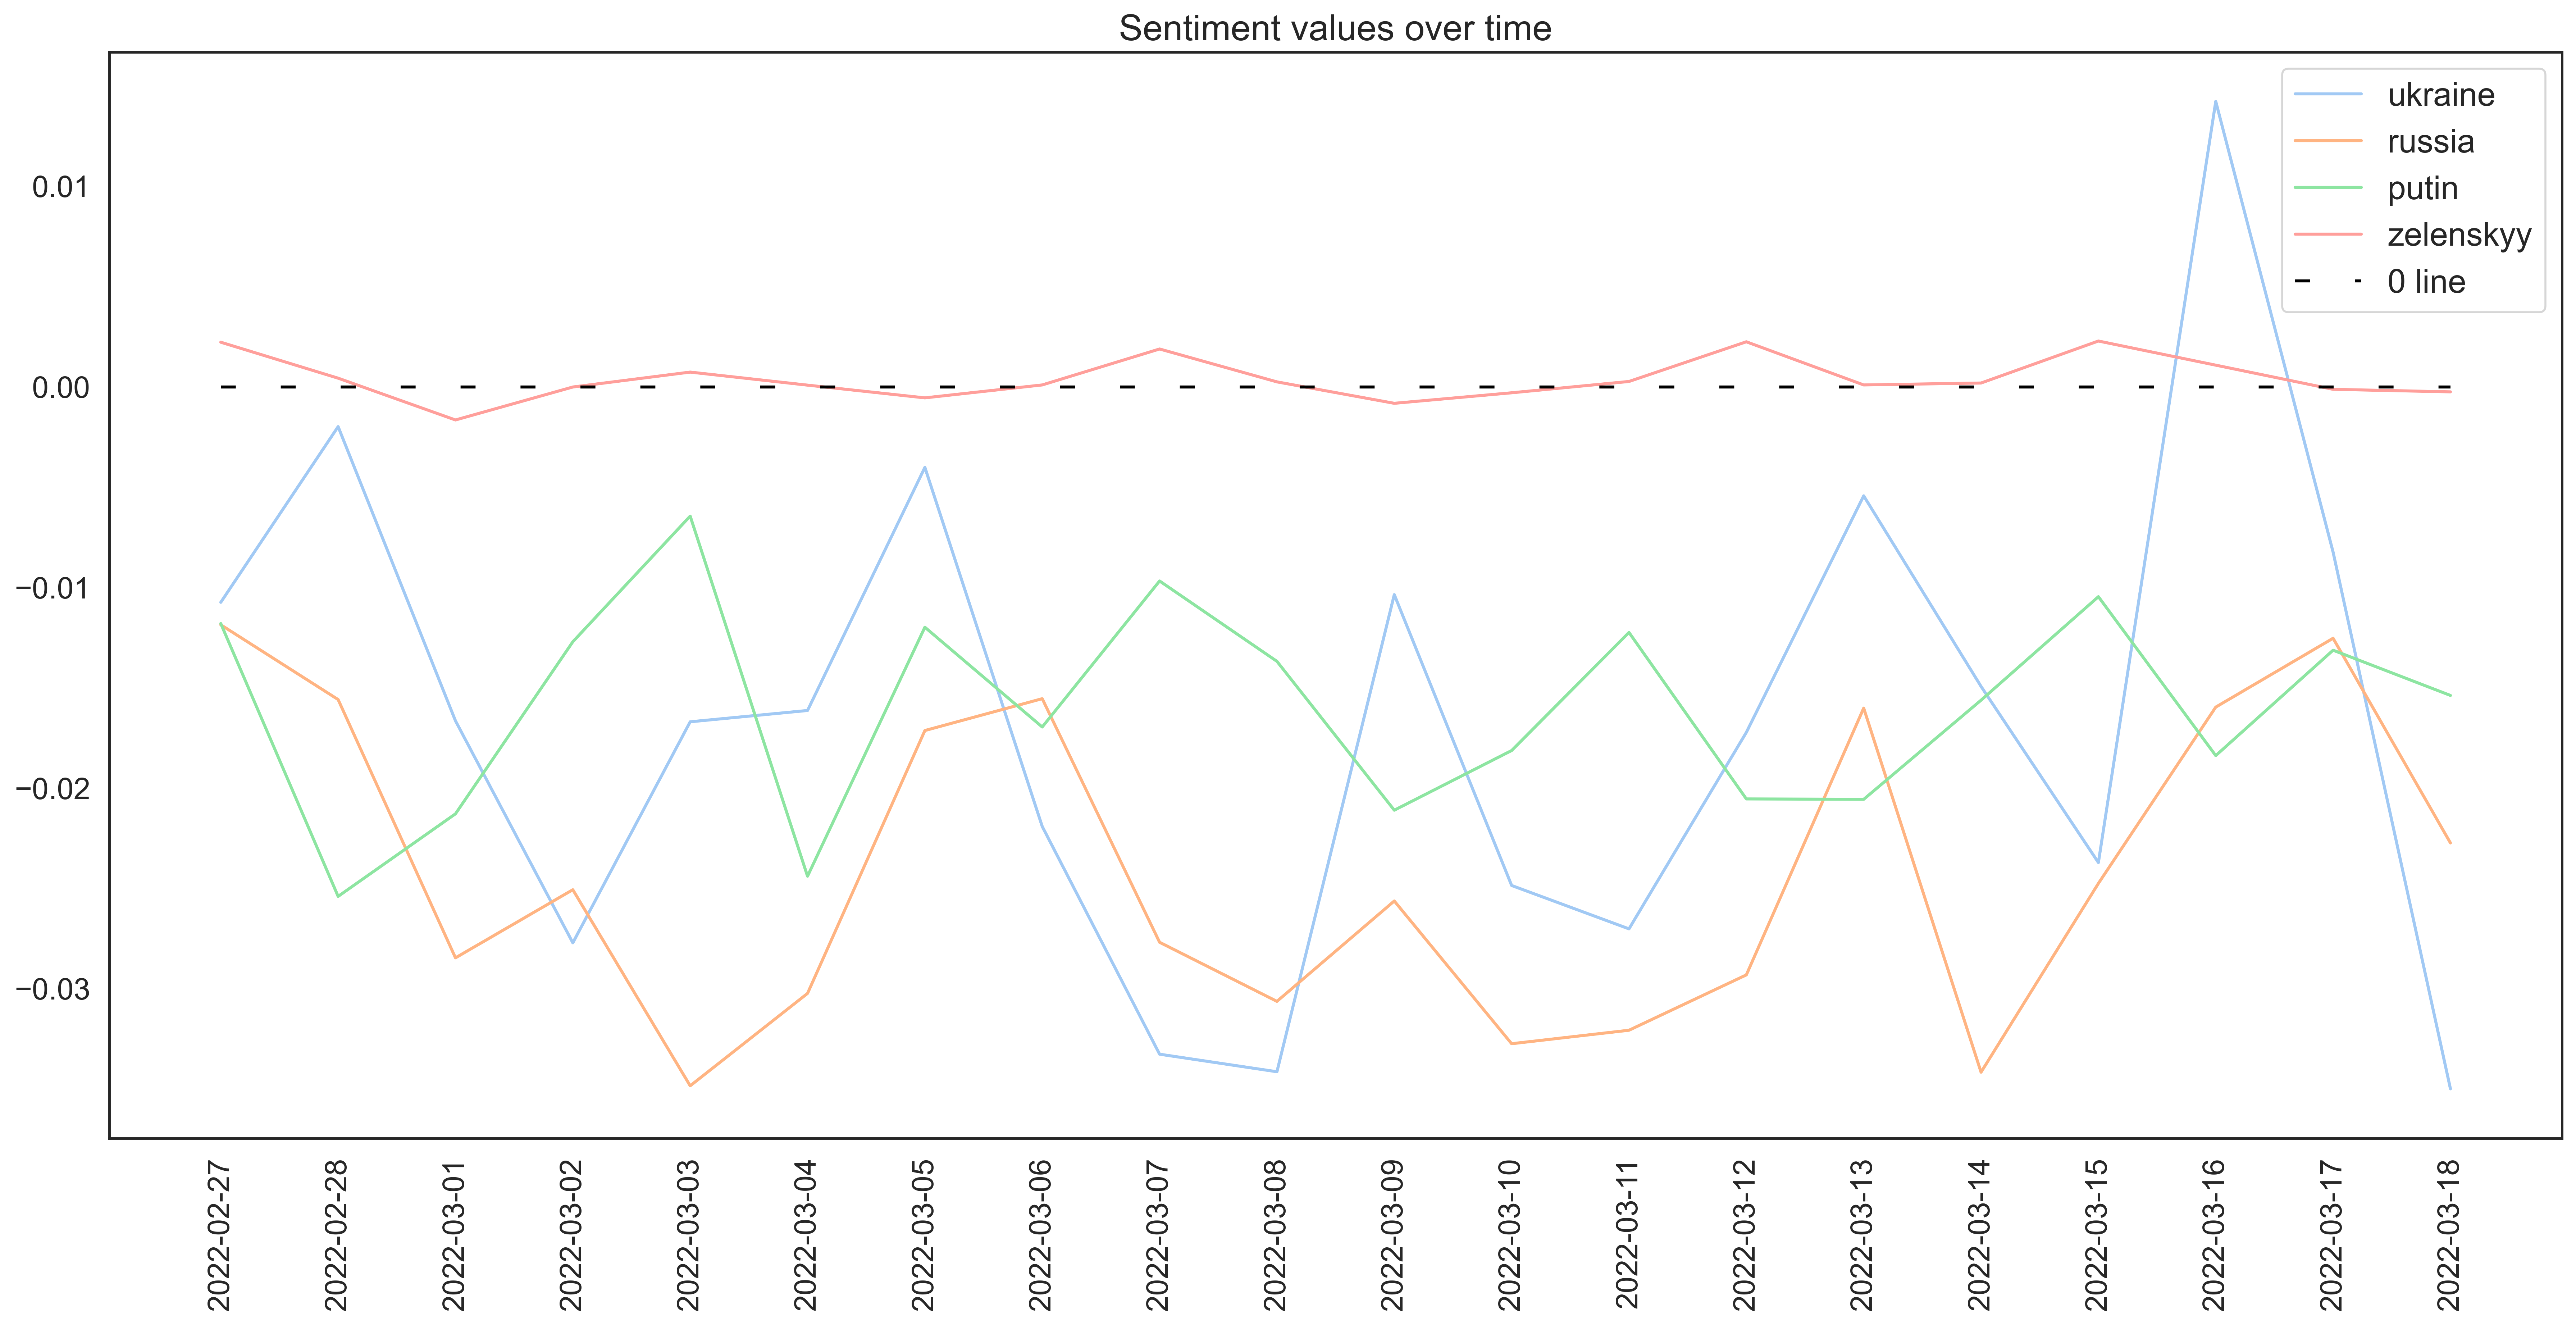

In [194]:
sentiment_plot(daily_sentiment, keys)


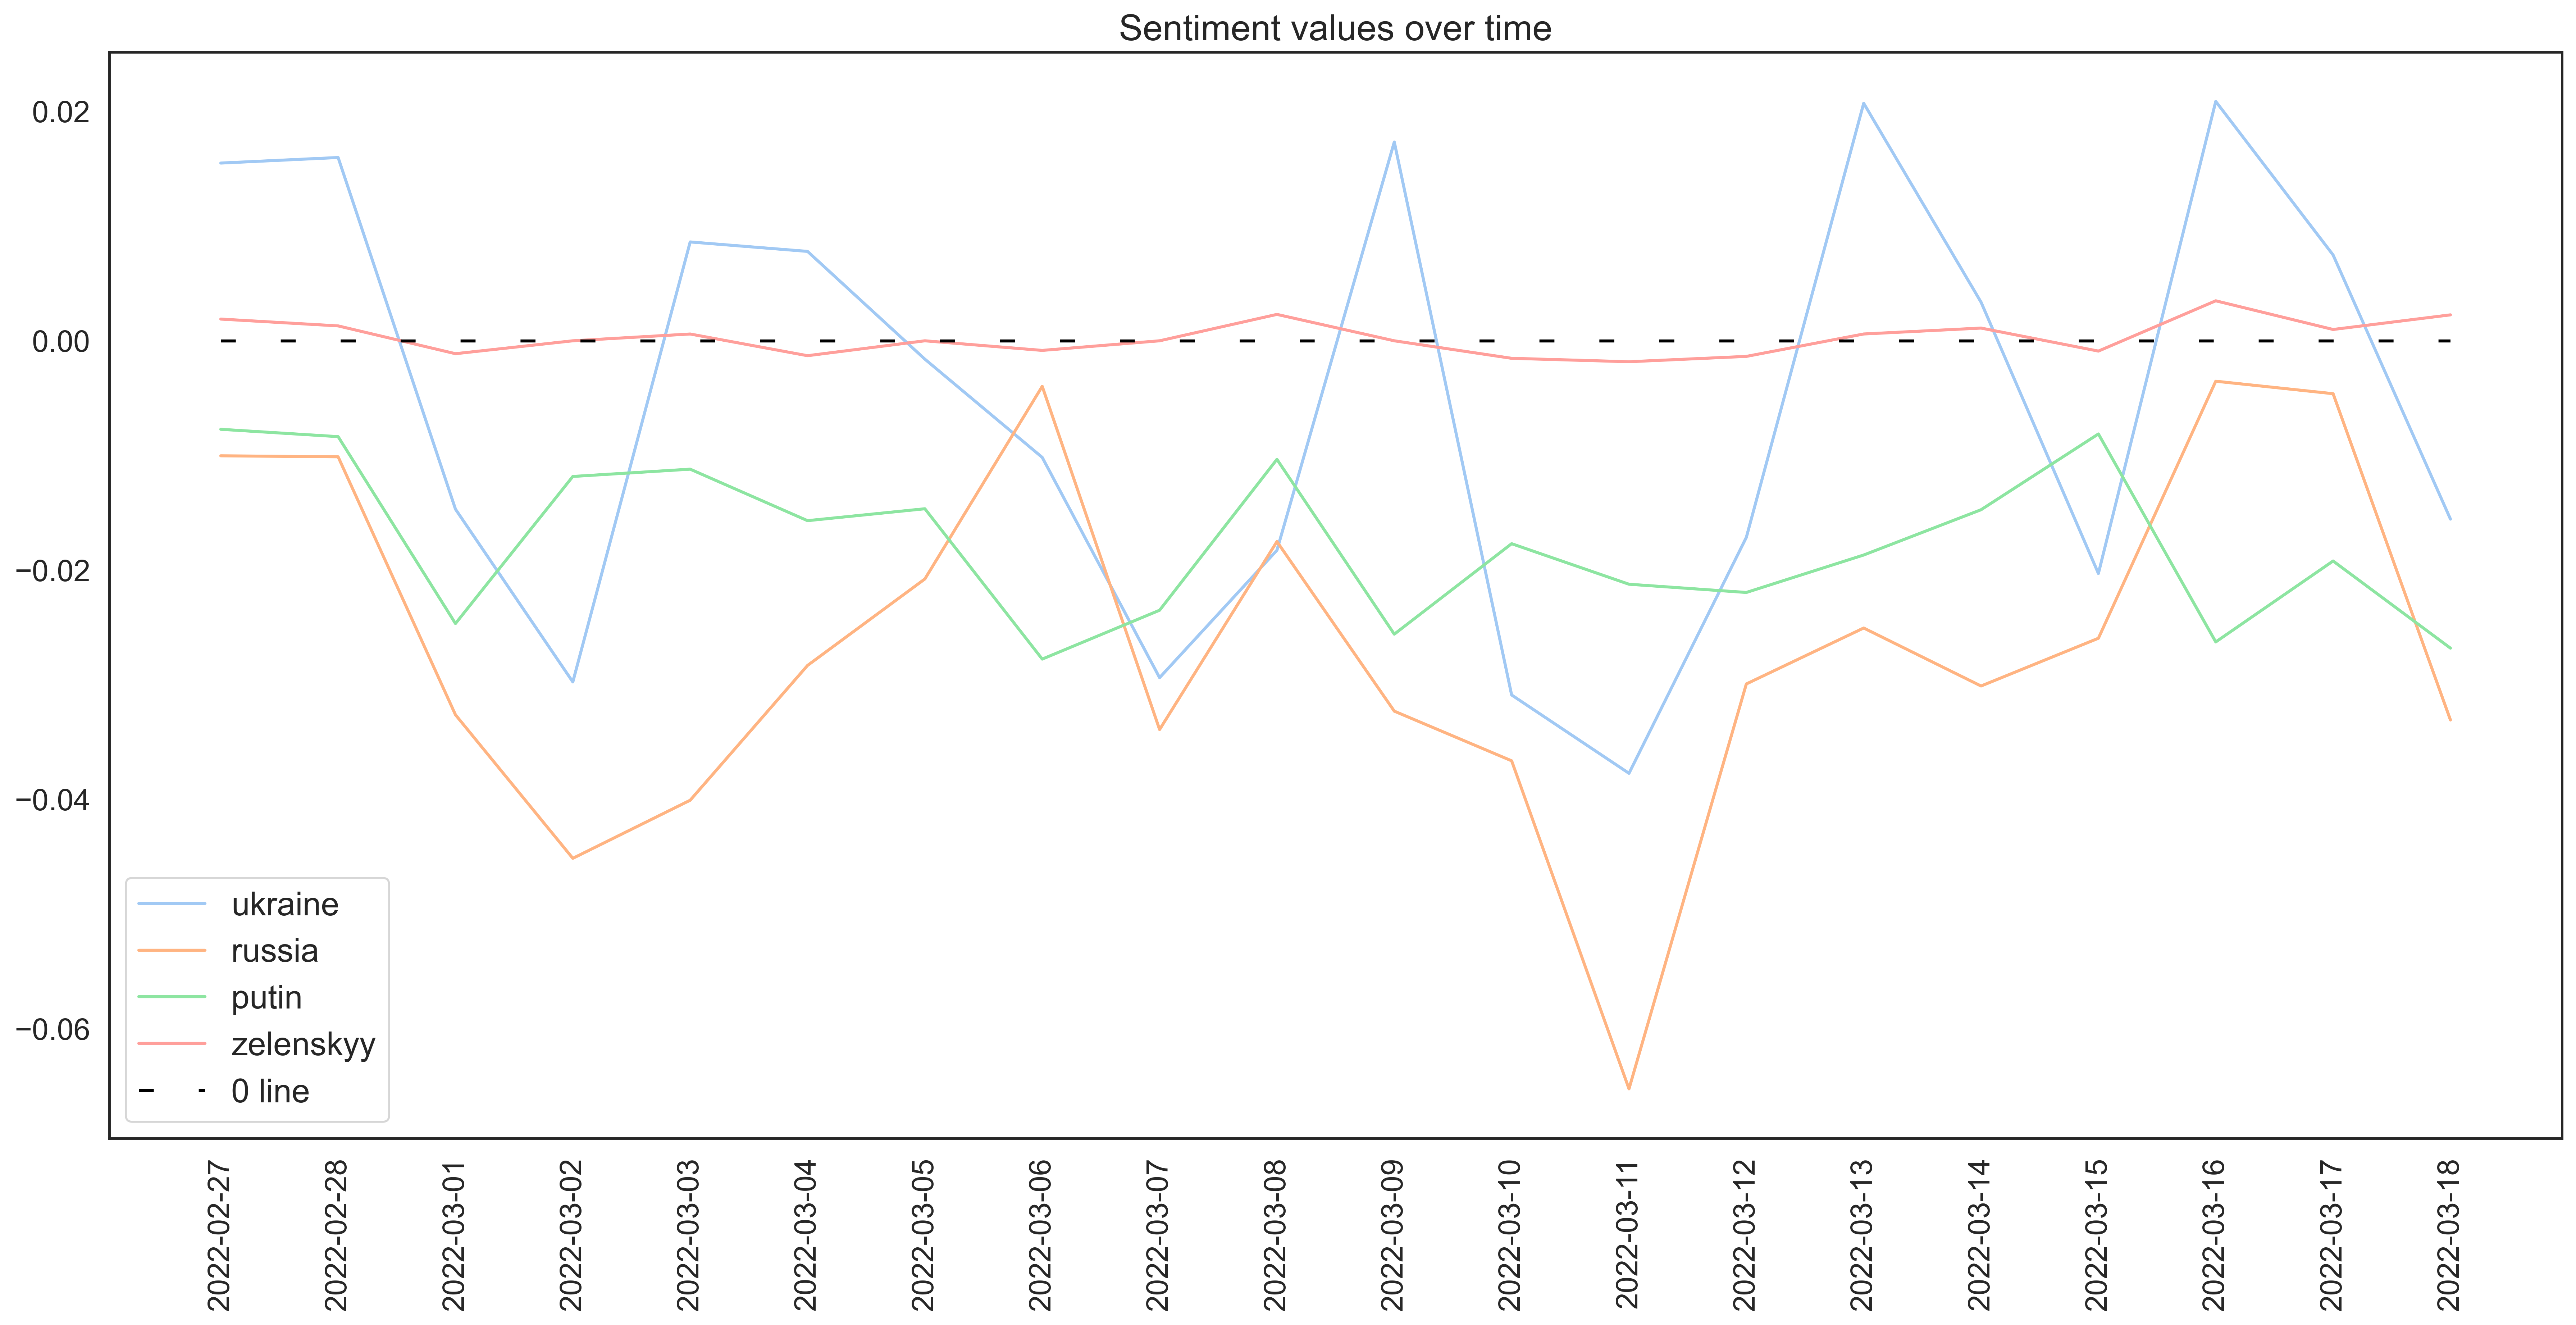

In [195]:
sentiment_plot(get_daily_sentiment(df_uk, keys), keys)

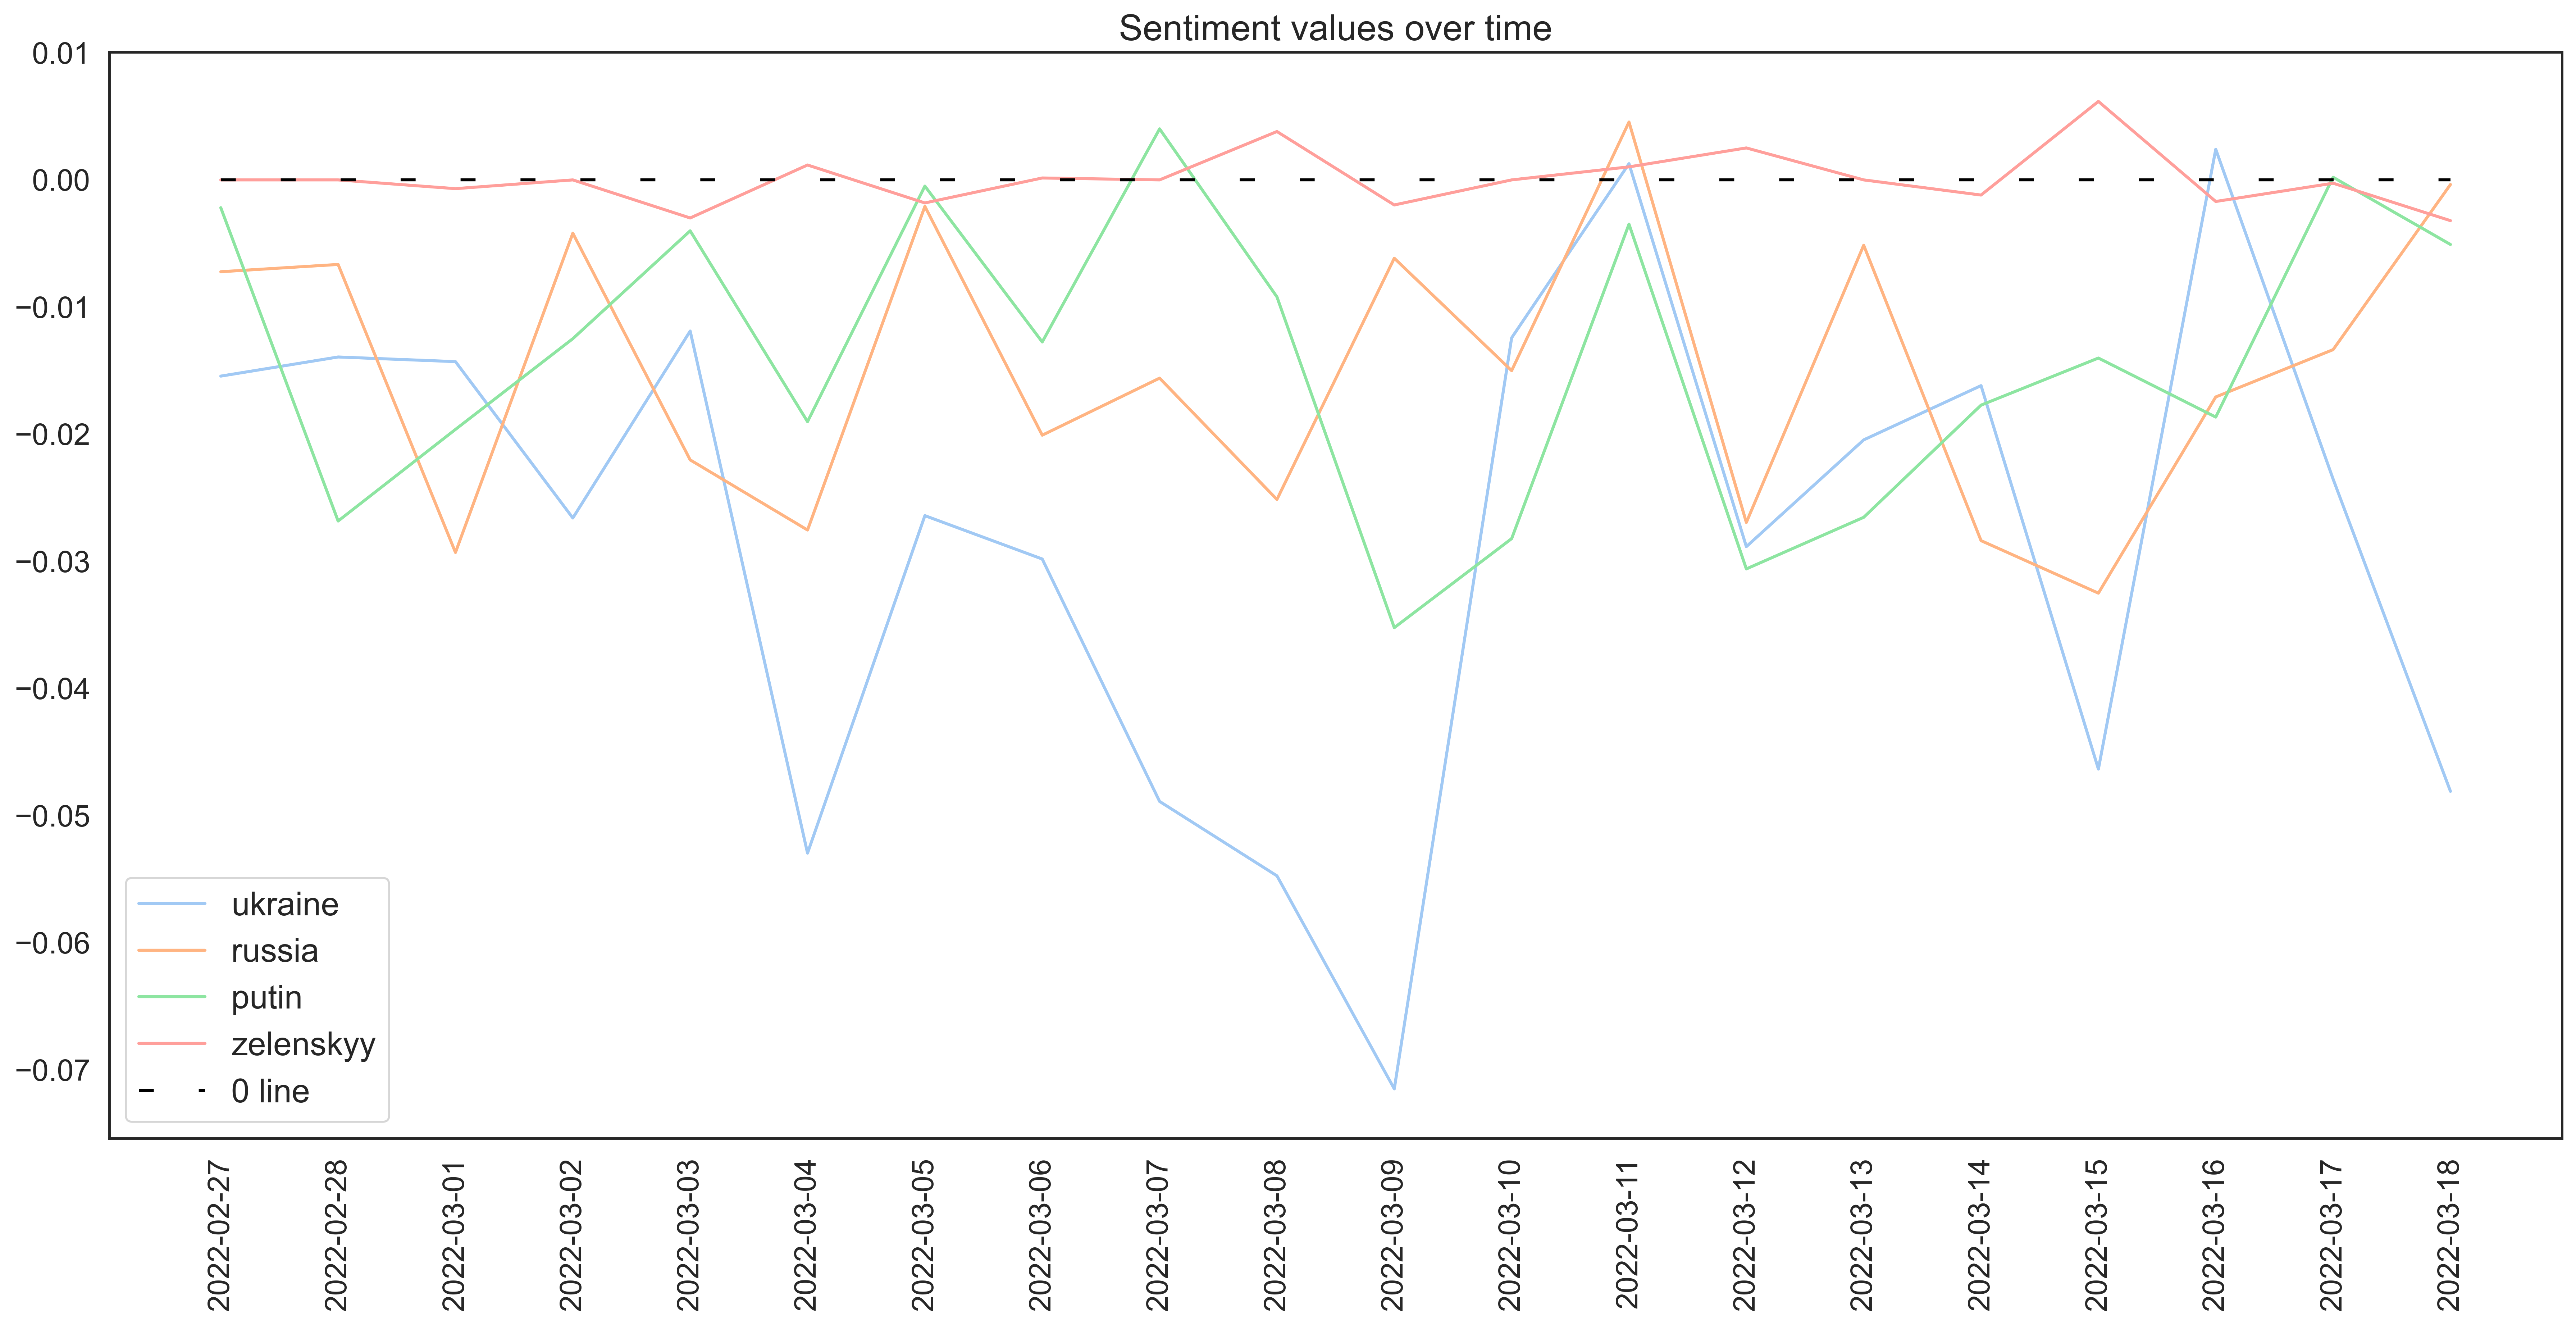

In [196]:
sentiment_plot(get_daily_sentiment(df_ru, keys), keys)


## Tweet based DF to User based DF

Now we convert out DF to one where we index by user, and all the users tweets are collected for each user. This is done for ease of networking.

In [211]:
df_ru_uk.columns

Index(['user_id', 'parent_id', 'lang', 'text', 'tweet_type', 'created_time',
       'hashtags', 'topics', 'mentions', 'iloc', 'nationality', 'en_text',
       'sentiment_dict', 'president_mentioned', 'date',
       'president_mention_idx', 'sentiment_scores'],
      dtype='object')

In [226]:
def make_user_df(old_df_name):
    user_dict = defaultdict(lambda : defaultdict(list))

    for i, (idx,tweet) in enumerate(zip(old_df_name.index,old_df_name.values)):
        essential_tweet_data = {
                        "tweet_ids": [idx],
                        "parent_ids": [tweet[1]],
                        "langs":[tweet[2]],
                        "texts":[tweet[3]],
                        "tweet_types":[tweet[4]],
                        "created_times":[tweet[5]],
                        "hashtags":[tweet[6]],
                        "topics":[tweet[7]], 
                        "mentions":[tweet[8]],
                        "nationality": [tweet[10]],
                        "en_text":[tweet[11]],
                        "overall_sentiement":[tweet[16]],
                        "word_wise_sentiement":[tweet[12]],
                        "president_mentioned":[tweet[13]],
                        "date":[tweet[14]],
                        "president_mention_idx":[tweet[15]],
                        }
        for index in essential_tweet_data:
            user_dict[tweet[0]][index] += essential_tweet_data[index]
    new_df_name = pd.DataFrame.from_dict(user_dict,orient="index")
    return new_df_name



In [227]:
df_user = make_user_df(df_ru_uk)

## War opinion based on sentiment


In [228]:
def president_conversion(presidents):
    """
    0 -> No presidents
    1 -> putin
    2 -> zelenskyy
    3 -> putin and zelenskyy
    """
    return ('putin' in presidents) + ('zelenskyy' in presidents) * 2

def get_anti_war_score(df):
    anti_war_score = []
    for i in range(len(df)):
        user_data = df.iloc[i]
        score = 0
        count = 0
        for s in user_data['word_wise_sentiment']:
            if s is not None:
                score += s['ukraine']['compound'] + s['zelenskyy']['compound'] - (s['russia']['compound'] + s['putin']['compound'])
                count += 1
        score = score/count if count != 0 else None
        anti_war_score.append(score)
    return anti_war_score

def classify_anti_war_score(aws):
    """
    1 -> Russia Supporter
    2 -> Ukraine Supporter
    3 -> Neutral
    """
    return (aws < 0) + (aws > 0) * 2 + (aws == 0) * 3 if aws is not None else None

In [221]:
df_user['overall_sentiment'] = df_user['overall_sentiement']
df_user['word_wise_sentiment'] = df_user['word_wise_sentiement']

In [222]:
if 'anti-war' not in df_user.columns:
    anti_war_score = get_anti_war_score(df_user)
    df_user['anti-war'] = anti_war_score
    print('added anti war')
    df_user['anti-war-class'] = [classify_anti_war_score(aws) for aws in anti_war_score]

added anti war


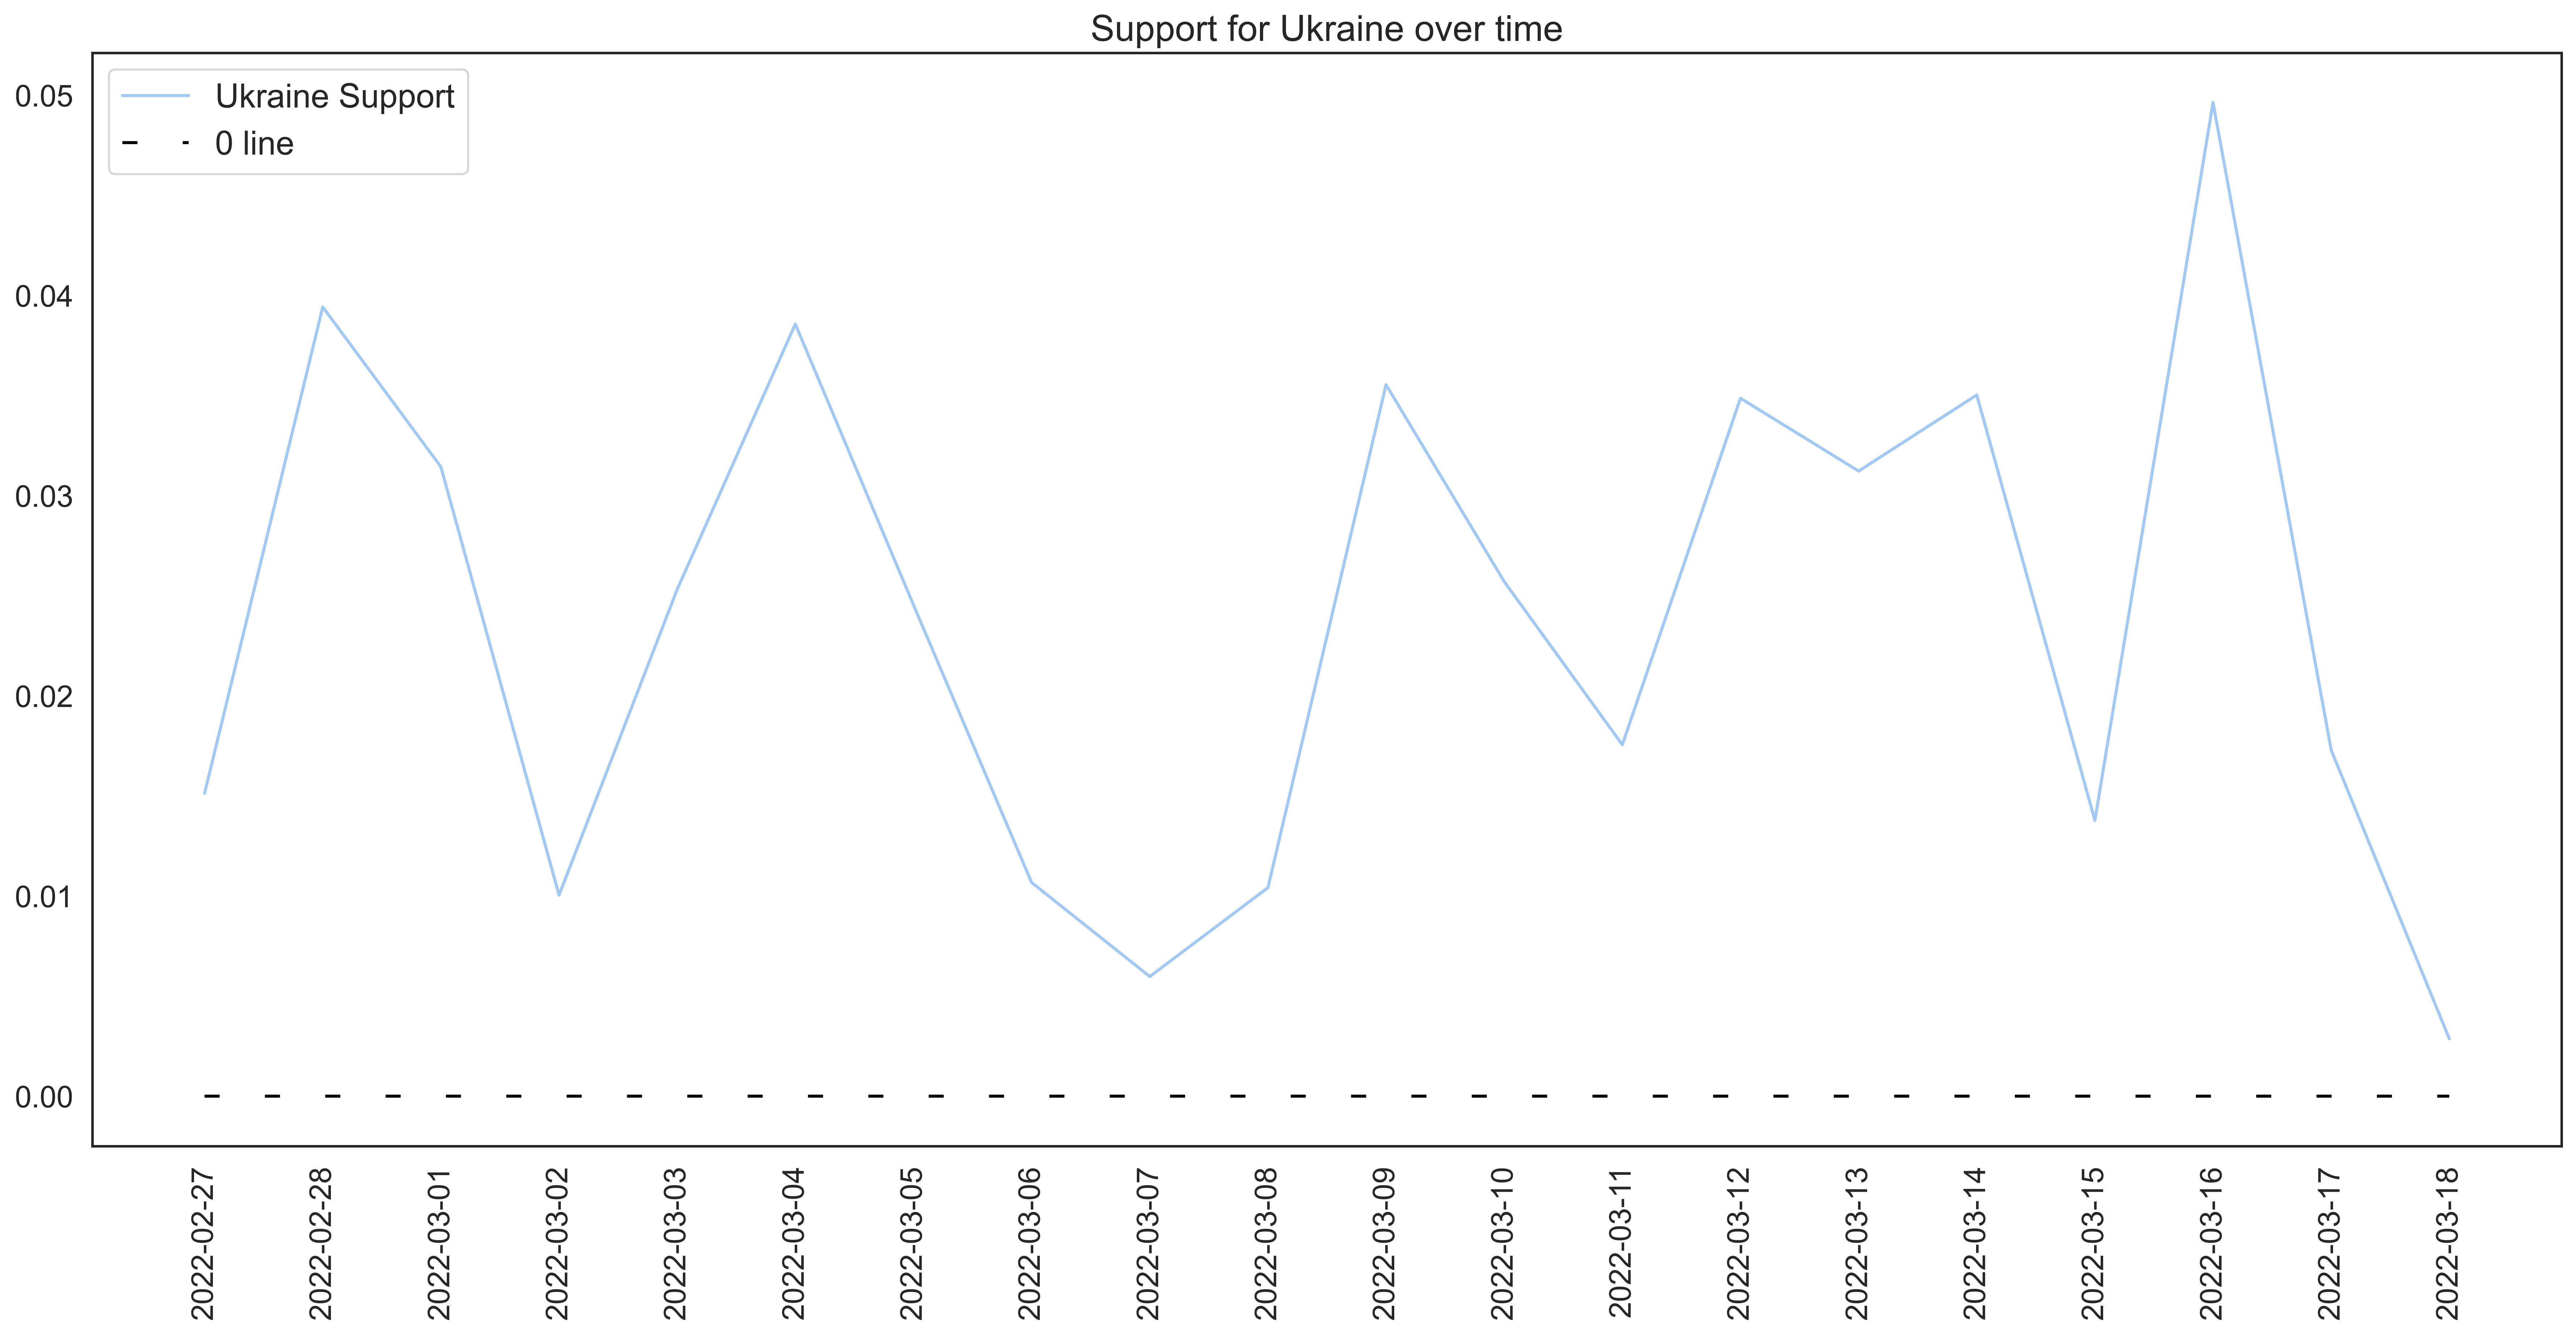

In [229]:
def anti_war_score_plot(sentiment_dict, keys, title=None):
    fig, ax = plt.subplots(figsize=(22,10),dpi=400)
    plt.xticks(rotation=90,fontsize=15)
    plt.yticks(fontsize=15)
    x, sentiment_values = zip(*sentiment_dict.items())
    ax.plot(x, [(s['ukraine'] + s['zelenskyy'] - (s['russia'] + s['putin'])) for s in sentiment_values])

    ax.plot(x, np.zeros(len(x)), color='black', linestyle=(0,(5,15)))
    # Maybe not 0 line?
    #ax.legend(labels=['Russia Support','0 line'])
    #plt.title('Support for Russia over time' if title is None else title)
    ax.legend(labels=['Ukraine Support','0 line'])
    plt.title('Support for Ukraine over time' if title is None else title)
    plt.show()
    plt.close()

anti_war_score_plot(daily_sentiment, keys)

## Network

We create two graphs, based on the same data, one where we only look at connections to other users in the data, and one where we look at all connections from the users. These aer caleld the "small" and "big" graphs.

In [58]:
import networkx as nx
import netwulf as nw
user_df = pd.read_pickle("./preprocessing/dfs/user_trans_senti_ru_uk.pkl")

In [59]:
re_quote = r"\'(.*?)\'"

def get_graph(df, small = False):

    edges = defaultdict(int)
    for i,(user_id,parents,mentions) in enumerate(zip(user_df.index,user_df["parent_ids"],user_df["mentions"])):
        
        ids = []
        for par in parents:
            if par is not None:
                ids.append(int(par))

        for ment in mentions:
            if ment != []:
                ids += [int(m[0]) for m in ment]

        for target_id in set(ids):
            if str(target_id) in user_df.index or not small:
                edges[(int(user_id),target_id)] += 1

    dG_func = nx.DiGraph()
    dG_func.add_edges_from(list(edges))
    return dG_func

dG_small = get_graph(user_df, small = True)
dG_big = get_graph(user_df, small = False)

### Basic Graph info

In [62]:
def get_graph_info(dG):
    N_edges = len(dG.edges)
    N_nodes = len(dG.nodes)

    print(f"N nodes: {N_nodes}\nN_edges: {N_edges}")

    dG_dens = nx.density(dG)

    print(f"Graph density: {dG_dens}")

    avg_in_degree = np.mean(list(dict(dG.in_degree()).values()))
    avg_out_degree = np.mean(list(dict(dG.out_degree()).values()))

    print(f"avg in degree: {avg_in_degree}\navg out degree: {avg_out_degree}")

    median_in_degree = np.median(list(dict(dG.in_degree()).values()))
    median_out_degree = np.median(list(dict(dG.out_degree()).values()))

    print(f"median in degree: {median_in_degree}\nmedian out degree: {median_out_degree}")

    max_in_degree = sorted(list(dict(dG.in_degree()).values()))[-5:]
    max_out_degree = sorted(list(dict(dG.out_degree()).values()))[-5:]

    print(f"top 5 in degree: {max_in_degree}\ntop 5 out degree: {max_out_degree}")

print("The Big graph:")
get_graph_info(dG_big)


print("\nThe Small graph:")
get_graph_info(dG_big)

The Big graph:
N nodes: 20687
N_edges: 19195
Graph density: 4.485533263726207e-05
avg in degree: 0.9278774109344032
avg out degree: 0.9278774109344032
median in degree: 1.0
median out degree: 0.0
top 5 in degree: [41, 51, 63, 68, 79]
top 5 out degree: [59, 68, 90, 107, 139]

The Small graph:
N nodes: 20687
N_edges: 19195
Graph density: 4.485533263726207e-05
avg in degree: 0.9278774109344032
avg out degree: 0.9278774109344032
median in degree: 1.0
median out degree: 0.0
top 5 in degree: [41, 51, 63, 68, 79]
top 5 out degree: [59, 68, 90, 107, 139]


### Analyse degrees:

A little noise is added to acutally see the number of nodes with the different degrees.

In [64]:
def get_degree_group_info(dG):
    x_i = np.array(dG.in_degree)[:,1].reshape(-1,1)
    x_o = np.array(dG.out_degree)[:,1].reshape(-1,1)

    colours = ["grey","red","blue","black","lightgray"]
    x_c = []
    x_g = {}
    groups = [[],[],[],[],[]]
    for id in np.array(dG.out_degree)[:,0]:
        if str(id) in user_df.index:
            idx = user_df.loc[str(id)]["anti-war-class"]
            if not np.isnan(idx):
                x_c.append(colours[int(idx)])
                x_g[id] = colours[int(idx)]
                groups[int(idx)].append(id)
            else:
                x_c.append(colours[-1])
                x_g[id] = colours[-1]
                groups[-1].append(id)
            
        else:
            x_c.append(colours[0])
            x_g[id] = colours[0]
            groups[0].append(id)

    return x_i, x_o ,x_c, x_g, groups

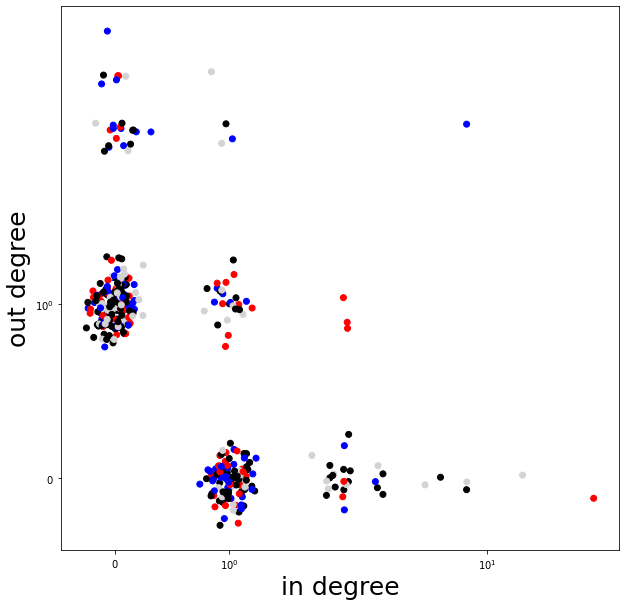

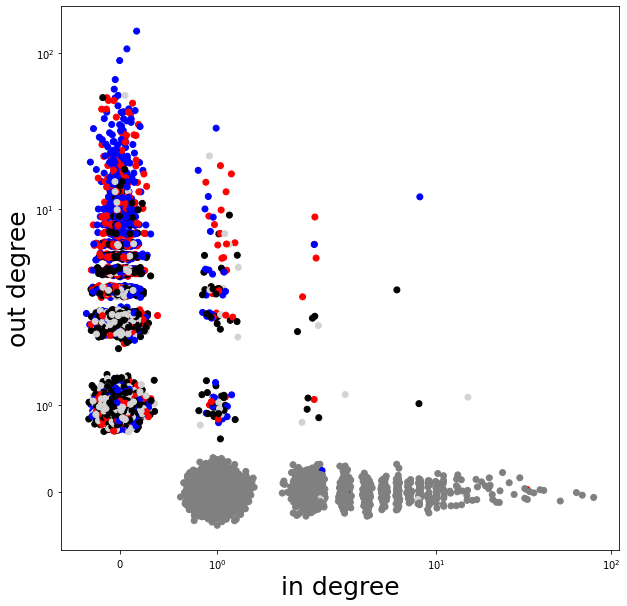

In [66]:
def in_out_plot(dG,sorted=False):

    x_i, x_o ,x_c, x_g, groups = get_degree_group_info(dG)
    tweet_colours_ordered = np.array(x_c)
    degrees = np.hstack((x_i,x_o))
    if sorted:
        sort_idx = np.argsort(degrees[:,0],axis=0)
        sorted_degrees = degrees[sort_idx]
        degrees = sorted_degrees

    fig,ax = plt.subplots(figsize = (10,10))
    n1 =np.random.normal(np.zeros(len(degrees)),0.1)
    n2 =np.random.normal(np.zeros(len(degrees)),0.1)
    ax.scatter(degrees[:,0]+n1,degrees[:,1]+n2,color = tweet_colours_ordered)

    ax.set_xscale("symlog")
    ax.set_yscale("symlog")
    ax.set_xlabel("in degree",fontsize = 25)
    ax.set_ylabel("out degree",fontsize = 25)

in_out_plot(dG_small)
in_out_plot(dG_big)

### Visualize Networks

The visualizations are commented out, as they run in browser and stop everything when running.

In [67]:
def visualize_net(dG):
    x_i, x_o ,x_c, x_g, groups = get_degree_group_info(dG)
    for k, v in dG.nodes(data=True):
        v['group'] = x_g[k]

    nw.visualize(dG)

In [68]:
# visualize_net(dG_small)

In [ ]:
# visualize_net(dG_big)

### Modularity

In [71]:
import seaborn as sns
sns.set_theme(style="white", palette='pastel', font = 'Arial', font_scale=1)

In [69]:
def modularity_tests(dG, N = 10000):

    x_i, x_o ,x_c, x_g, groups = get_degree_group_info(dG)
    uG = dG.to_undirected(reciprocal = False)

    real_modularity = nx.community.modularity(uG,groups)

    random_modularities = []
    for _ in range(N):
        g = nx.double_edge_swap(uG)
        random_modularities.append( nx.community.modularity(g,groups))

    rand_modul_mean = np.mean(random_modularities)
    rand_modul_std = np.std(random_modularities)

    # fig,ax = plt.subplots()
    ax = sns.histplot(random_modularities,kde=True)
    ax.axvline(real_modularity,color="black",label="True modularity")

    ax.legend()
    ax.set_title("Modularity of random network (double swap algorithm)")
    ax.set_ylabel("Number of networks with the given modularity")
    ax.set_xlabel("Modularity")
    print(f"Modularity for random nets: {rand_modul_mean} pm {rand_modul_std}")

Modularity for random nets: 0.008520909890792416 pm 0.02567190735583105


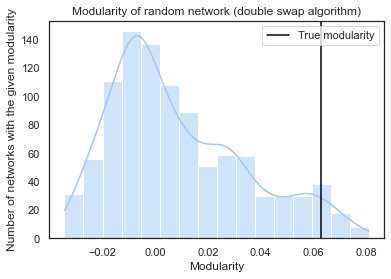

In [72]:
modularity_tests(dG_small,N=1000)

Modularity for random nets: -0.2995196046556826 pm 0.00869730780283862


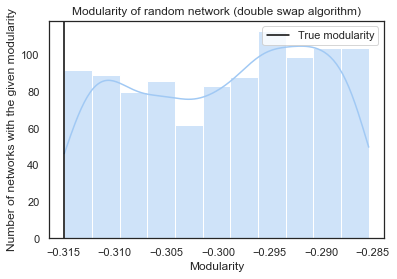

In [73]:
modularity_tests(dG_big,N=1000)


### Louvian partitioning

In [74]:
import community as lou
def get_louvain_graph(dG, visualize = False):
    uG = dG.to_undirected(reciprocal = False)
    lou_partition = lou.best_partition(uG) 
    lou_mod = lou.modularity(lou_partition,uG)
    lou_mod
    
    uG_lou = uG
    for k, v in uG_lou.nodes(data=True):
        v['group'] = lou_partition[k]

    if visualize:
        nw.visualize(uG_lou)

    return uG_lou, lou_partition

In [92]:
ug_small_lou, lou_partition_small = get_louvain_graph(dG_small, visualize = False)

In [76]:
ug_big_lou, lou_partition_big = get_louvain_graph(dG_big, visualize = False)


In [93]:
def lou_modul(uG, N= 1000, groups = lou_partition_small):

    lou_groups = defaultdict(list)

    for id,g in zip(groups,groups.values()):
        lou_groups[g] += [id]

    real_lou_groups = []
    for i in range(len(lou_groups)):
        real_lou_groups.append(lou_groups[i])


    real_modularity = nx.community.modularity(uG,real_lou_groups)

    random_modularities = []
    for _ in range(N):
        g = nx.double_edge_swap(uG)
        random_modularities.append(nx.community.modularity(g,real_lou_groups))

    rand_modul_mean = np.mean(random_modularities)
    rand_modul_std = np.std(random_modularities)

    # fig,ax = plt.subplots()
    ax = sns.histplot(random_modularities,kde=True)
    ax.axvline(real_modularity,color="black",label="True modularity")

    ax.legend()
    ax.set_title("Louvian partition: Modularity of random network (double swap algorithm)")
    ax.set_ylabel("Number of networks with the given modularity")
    ax.set_xlabel("Modularity")
    print(f"Modularity for random nets: {rand_modul_mean} pm {rand_modul_std}")

Modularity for random nets: 0.1088887221158324 pm 0.21093416284426442


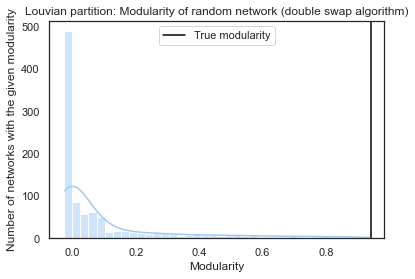

In [94]:
lou_modul(ug_small_lou, N= 1000, groups = lou_partition_small)

Modularity for random nets: 0.8725349156958295 pm 0.0267553448134643


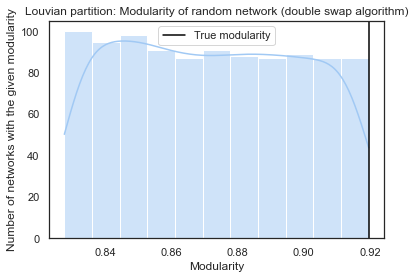

In [95]:
lou_modul(ug_big_lou, N= 1000, groups = lou_partition_big)


### Nationality vs war opinion


In [100]:
def nation_v_war_op(grp):
    uk = [[],[],[]]
    ru = [[],[],[]]

    groups_cut = grp[1:4]

    for i,lis in enumerate(groups_cut):
        for id in lis:
            nat = user_df.loc[str(id)]["nationality"][0]

            if nat == "ru":
                ru[i].append(id)

            elif nat == "uk":
                uk[i].append(id)
            else:
                print(nat)

    print("uk natrionality")
    for lis in uk:
        print(len(lis))

    print("  ")

    print("ru natrionality")
    for lis in ru:
        print(len(lis))

Den første af de 3 er hvor mange der støtter krigen, nr.2 er hvor mange der er imod krigen, og den sidte er hvor mange der er neutrale omkring krigen.

In [101]:
_,_,_,_, groups_big = get_degree_group_info(dG_big)
nation_v_war_op(groups_big)

uk natrionality
311
477
729
  
ru natrionality
848
995
1882


In [102]:
_,_,_,_, groups_small = get_degree_group_info(dG_small)
nation_v_war_op(groups_small)

uk natrionality
13
28
34
  
ru natrionality
63
63
109


### Connected to people of differing opinion

In [230]:
def recursive_next_node(uG, node, parent_node, value_dict, c=1):

    if c == 0:
        return value_dict[node]

    proxy_val = 0
    for edge in uG.edges(node):

        if edge[1] == parent_node:
            continue

        elif edge[1] == node:
            proxy_val += value_dict[node]
            continue

        proxy_val += recursive_next_node(uG, edge[1], edge[0], value_dict = value_dict, c=c-1)

    return proxy_val

def n_steps_value(uG, origin_node, c = 2):
    
    # ["grey","red","blue","black","lightgray"]
    colour_scores = [0,-1,1,0,0]
    value_dict = {}
    for i,list in enumerate(groups):
        for node in list:
            value_dict[node] = colour_scores[i]

    sign = value_dict[origin_node]

    return sign * recursive_next_node(uG, origin_node, 0, value_dict = value_dict, c=c)



In [233]:
graph = dG_small
uG = graph.to_undirected(reciprocal = False)
_,_,_,_, groups = get_degree_group_info(graph)

# ["grey","red","blue","black","lightgray"]
ru_gang = groups[2]
uk_gang = groups[1]
gangs = [ru_gang,uk_gang]
adj_values_dict = [{},{}]
for i,gang in enumerate(gangs):
    for node in gang:
        adj_values_dict[i][node] = n_steps_value(uG, node, c = 2) * 0.5
        adj_values_dict[i][node] = n_steps_value(uG, node, c = 1)

In [4]:
# import seaborn as sns
# sns.set_theme(style="white", palette='pastel', font = 'Arial', font_scale=1)

# fig,ax = plt.subplots(figsize=(10,10))

# uk_sum = sum(adj_values_dict[1].values())
# uk_mean = np.mean(list(adj_values_dict[1].values()))
# uk_std = np.std(list(adj_values_dict[1].values()))

# ru_sum = sum(adj_values_dict[0].values())
# ru_mean = np.mean(list(adj_values_dict[0].values()))
# ru_std = np.std(list(adj_values_dict[0].values()))
# ax.set_title("Agreement within connections once removed",fontsize = 22)
# ax.set_ylabel("Degree of agreement",fontsize = 22)

# plt.bar(["Russia support","Ukrain support"],[ru_sum,uk_sum])
# ax.errorbar(["Russia support","Ukrain support"],[ru_sum,uk_sum],yerr = [ru_std,uk_std],fmt="o", color="black")


Aint got no time to run it now, so here is the correct one

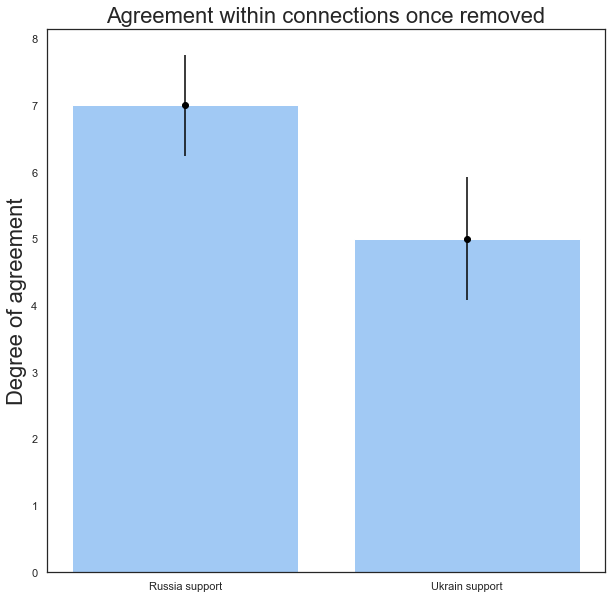

In [235]:
Image(filename="./img/once_removed_degree.png") 